# Лабораторная работа №2
Необходимые данные можно скачать [здесь](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data).

In [4]:
# Установка необходимых библиотек
%pip install folium scikit-learn pandas numpy matplotlib seaborn h3

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Создаем необходимые директории (если их нет)
!mkdir -p data/input/laboratory_work2 data/output/laboratory_work2
print("✓ Директории созданы")

✓ Директории созданы


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="darkgrid")
np.random.seed(0)

## Часть 0. Подготовка

### Задание 1: Загрузка данных

In [7]:
# Загружаем данные
df = pd.read_csv("data/input/laboratory_work2/train.csv")
print(f"Размер датасета: {df.shape}")
print("\nПервые строки:")
df.head()

Размер датасета: (1458644, 11)

Первые строки:


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [8]:
# Удаляем dropoff_datetime
df = df.drop('dropoff_datetime', axis=1)

# Преобразуем pickup_datetime в datetime объект
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

print("Информация о данных:")
df.info()

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


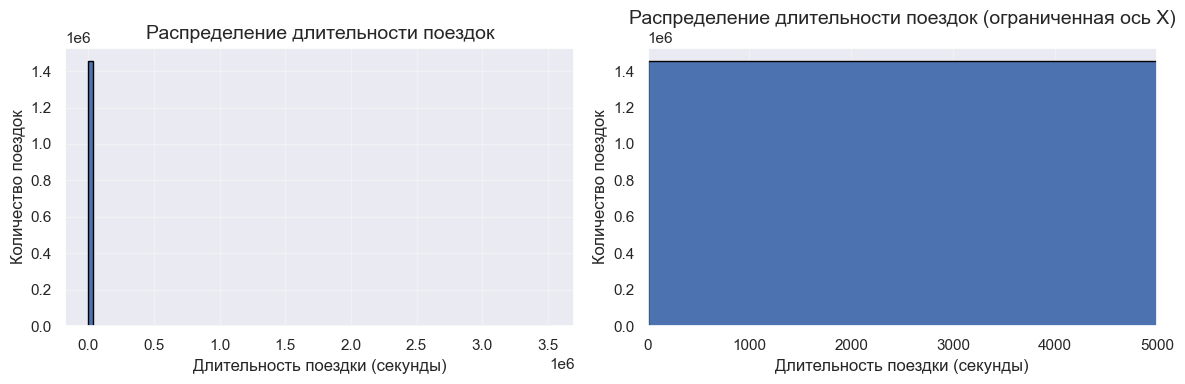

Статистика по trip_duration:
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64


<Figure size 640x480 with 0 Axes>

In [9]:
# Изучаем распределение целевой переменной
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['trip_duration'], bins=100, edgecolor='black')
plt.xlabel('Длительность поездки (секунды)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение длительности поездок', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['trip_duration'], bins=100, edgecolor='black')
plt.xlabel('Длительность поездки (секунды)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение длительности поездок (ограниченная ось X)', fontsize=14)
plt.xlim(0, 5000)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trip_duration_distribution.png")

print(f"Статистика по trip_duration:\n{df['trip_duration'].describe()}")

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Распределение сильно скошено вправо. Большинство поездок имеют небольшую длительность (до 1000-2000 секунд). Большинство поездок короткие, но есть редкие очень длинные поездки.

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: RMSLE менее чувствителен к выбросам и большим значениям, чем RMSE. Для данных с сильной правосторонней асимметрией (как у нас) RMSE будет сильно зависеть от нескольких очень больших значений, что сделает метрику менее репрезентативной для типичных поездок. RMSLE "сжимает" большие значения через логарифм, делая метрику более справедливой для всего диапазона значений.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:

Обозначим $\hat{y}_i = \log(y_i + 1)$ и $\hat{a}(x_i) = \log(a(x_i) + 1)$.

RMSLE для модели $a$:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (\hat{y}_i - \hat{a}(x_i))^2}$$

MSE для модели $\hat{a}$:
$$\text{MSE}(X, \hat{y}, \hat{a}) = \frac{1}{\ell}\sum_{i=1}^{\ell} (\hat{y}_i - \hat{a}(x_i))^2$$

Видно, что $\text{RMSLE}^2 = \text{MSE}$, следовательно минимизация RMSLE эквивалентна минимизации MSE для логарифмированных значений.

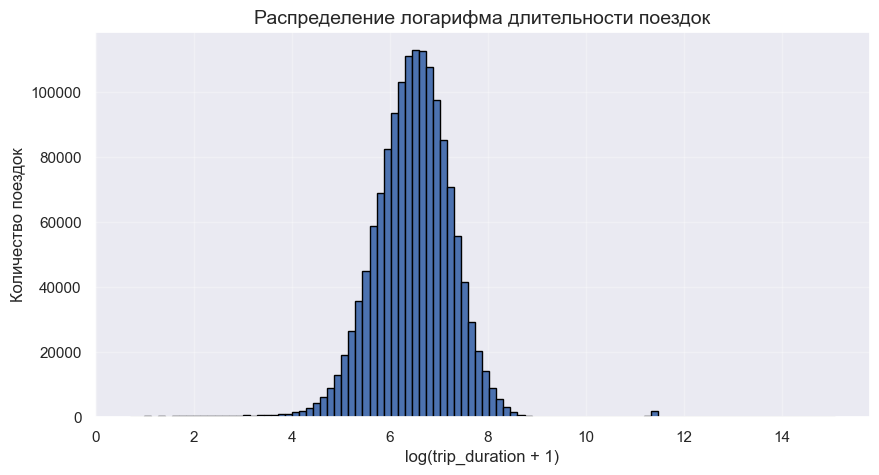

Статистика по log_trip_duration:
count    1.458644e+06
mean     6.466978e+00
std      7.957595e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.496775e+00
75%      6.981006e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64


<Figure size 640x480 with 0 Axes>

In [10]:
# Добавляем логарифм таргета
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# Удаляем исходный таргет
df = df.drop('trip_duration', axis=1)

# Визуализируем распределение логарифма
plt.figure(figsize=(10, 5))
plt.hist(df['log_trip_duration'], bins=100, edgecolor='black')
plt.xlabel('log(trip_duration + 1)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение логарифма длительности поездок', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("data/output/laboratory_work2/log_trip_duration_distribution.png")

print(f"Статистика по log_trip_duration:\n{df['log_trip_duration'].describe()}")

Распределение стало гораздо более симметричным и близким к нормальному, что лучше для линейной регрессии.

In [11]:
# Функция для расчета RMSLE
def rmsle(log1p_y_true, log1p_y_pred):
    """Вычисляет RMSLE для логарифмированных значений"""
    return np.sqrt(mean_squared_error(log1p_y_true, log1p_y_pred))

# Наилучшее константное предсказание - это среднее значение логарифма
best_const = df['log_trip_duration'].mean()
rmsle_best_const = rmsle(df['log_trip_duration'], np.full(len(df), best_const))

print(f"Наилучшее константное предсказание: {best_const:.4f}")
print(f"RMSLE для константного предсказания: {rmsle_best_const:.5f}")

assert np.allclose(rmsle_best_const, 0.79575, 1e-4), "Проверьте расчет RMSLE"

Наилучшее константное предсказание: 6.4670
RMSLE для константного предсказания: 0.79576


## Часть 1. Изучаем pickup_datetime (2 балла)

### Задание 2: Анализ времени

In [12]:
# Извлекаем временные признаки
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.date

print("Добавлены временные признаки")

Добавлены временные признаки


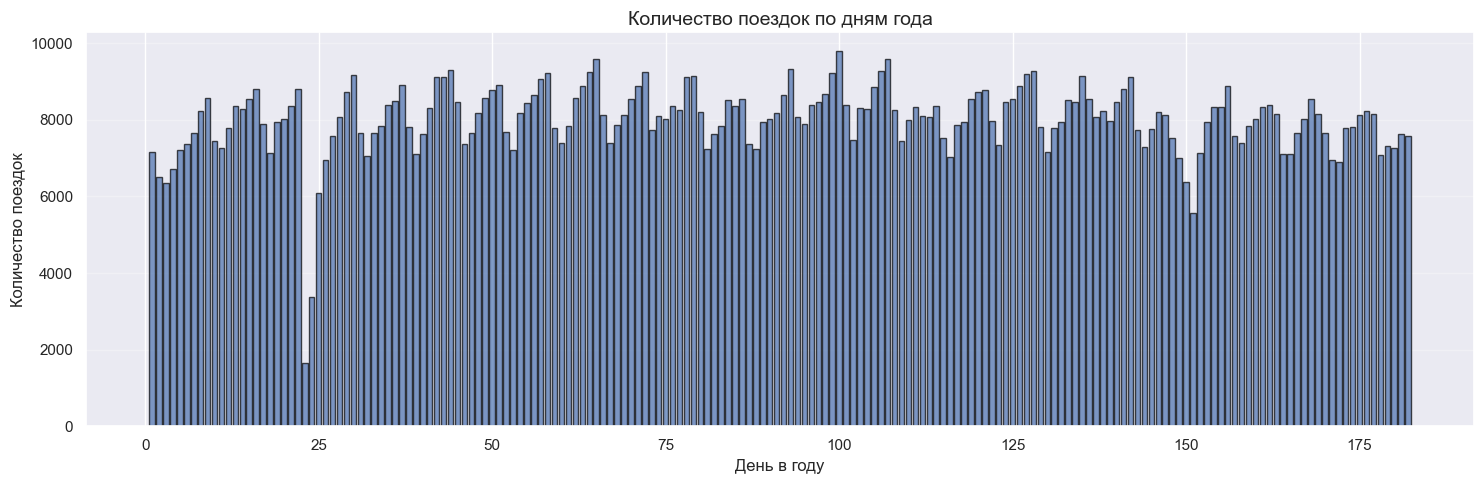


Аномальные дни (с малым количеством поездок):
День 2: 2016-01-02 - 6512 поездок
День 3: 2016-01-03 - 6353 поездок
День 4: 2016-01-04 - 6725 поездок
День 23: 2016-01-23 - 1648 поездок
День 24: 2016-01-24 - 3383 поездок
День 25: 2016-01-25 - 6084 поездок
День 26: 2016-01-26 - 6941 поездок
День 150: 2016-05-29 - 6372 поездок
День 151: 2016-05-30 - 5570 поездок
День 172: 2016-06-20 - 6910 поездок


<Figure size 640x480 with 0 Axes>

In [13]:
# График количества поездок по дням
plt.figure(figsize=(15, 5))
daily_counts = df.groupby('day_of_year').size()
plt.bar(daily_counts.index, daily_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('День в году', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по дням года', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_day.png")

# Найдем аномальные дни
anomaly_threshold = daily_counts.quantile(0.05)
anomalous_days = daily_counts[daily_counts < anomaly_threshold]
print(f"\nАномальные дни (с малым количеством поездок):")
for day in anomalous_days.index:
    date = pd.Timestamp(year=2016, month=1, day=1) + pd.Timedelta(days=int(day)-1)
    print(f"День {day}: {date.strftime('%Y-%m-%d')} - {anomalous_days[day]} поездок")

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: Два основных периода с низким количеством поездок:
1. **23-24 января 2016** - Снежная буря "Джонас" (Blizzard Jonas), одна из сильнейших метелей в истории Нью-Йорка. Город был практически парализован.
2. **Период вокруг 1 января** - Новогодние праздники, когда многие люди не работают и меньше пользуются такси.

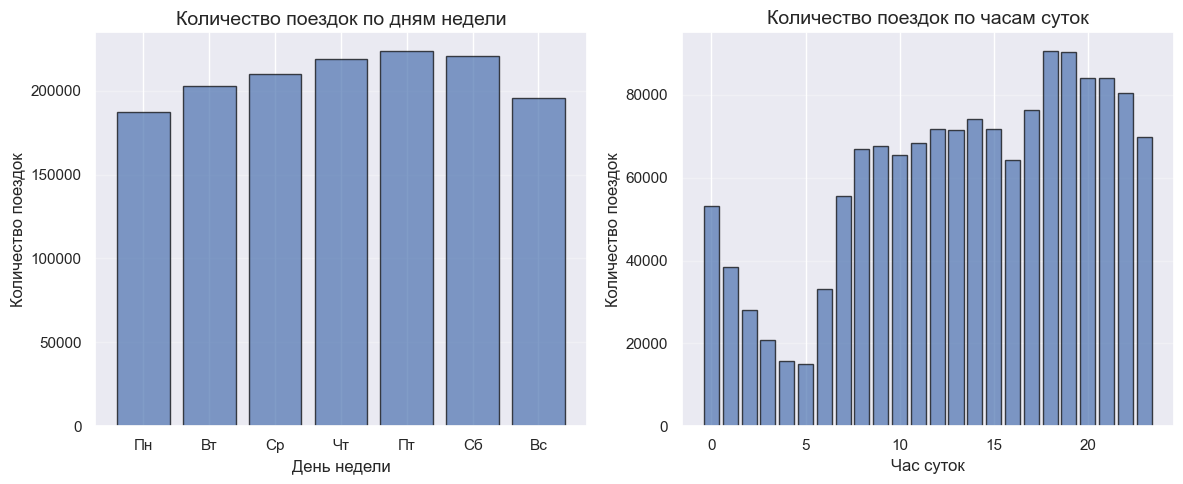

<Figure size 640x480 with 0 Axes>

In [14]:
# График по дням недели
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
weekday_counts = df.groupby('day_of_week').size()
plt.bar(range(7), weekday_counts.values, edgecolor='black', alpha=0.7)
plt.xticks(range(7), day_names)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по дням недели', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График по часам
plt.subplot(1, 2, 2)
hour_counts = df.groupby('hour').size()
plt.bar(hour_counts.index, hour_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по часам суток', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_weekday_hour.png")

### Задание 3: Детальный анализ времени

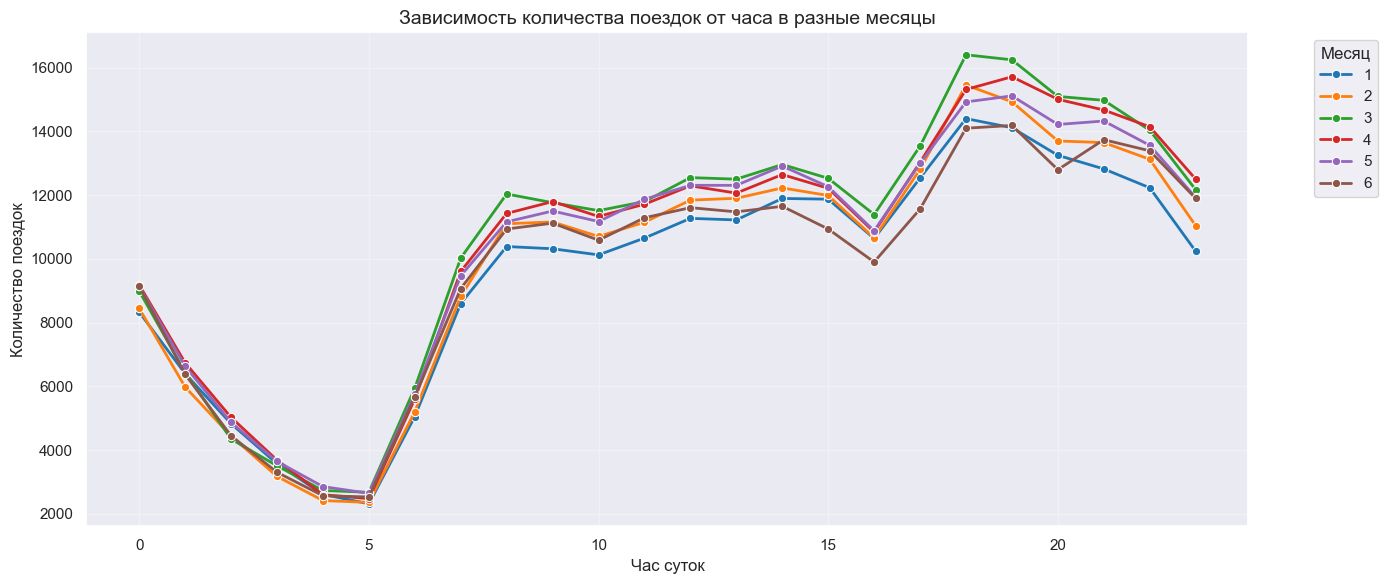

<Figure size 640x480 with 0 Axes>

In [15]:
# График зависимости количества поездок от часа для разных месяцев
plt.figure(figsize=(14, 6))

hour_month_counts = df.groupby(['hour', 'month']).size().reset_index(name='count')
sns.lineplot(data=hour_month_counts, x='hour', y='count', hue='month',
             palette='tab10', marker='o', linewidth=2)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Зависимость количества поездок от часа в разные месяцы', fontsize=14)
plt.legend(title='Месяц', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_month_hour.png")

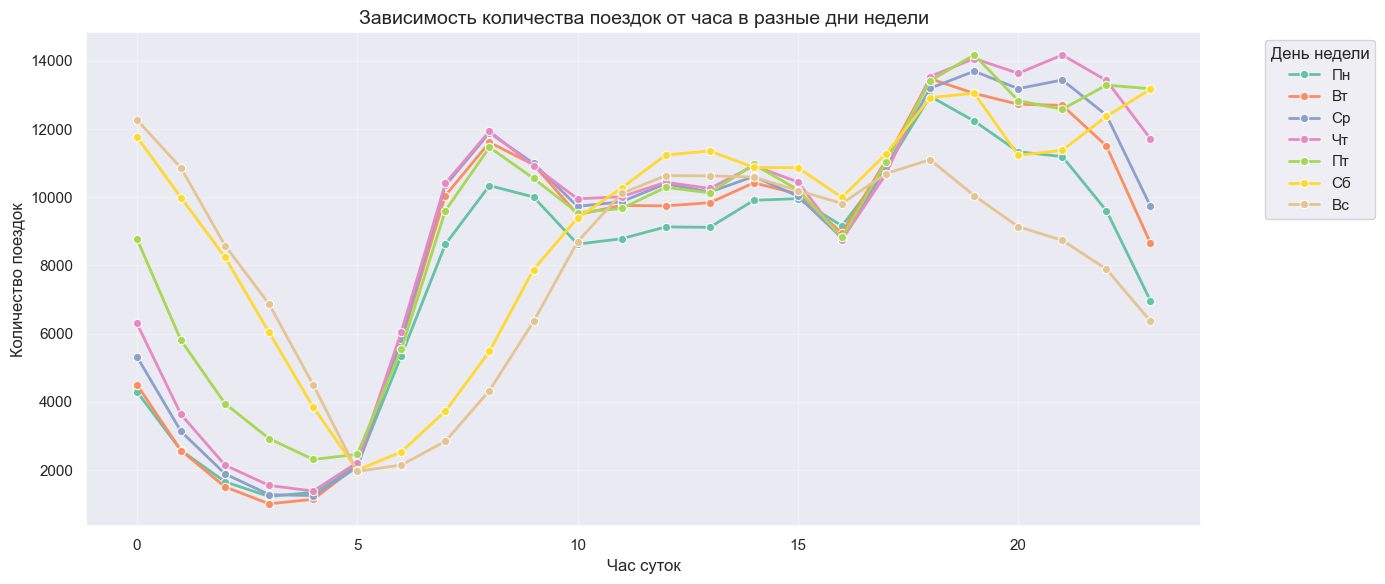

<Figure size 640x480 with 0 Axes>

In [16]:
# График зависимости количества поездок от часа для разных дней недели
plt.figure(figsize=(14, 6))

hour_weekday_counts = df.groupby(['hour', 'day_of_week']).size().reset_index(name='count')
day_names_dict = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
hour_weekday_counts['day_name'] = hour_weekday_counts['day_of_week'].map(day_names_dict)

sns.lineplot(data=hour_weekday_counts, x='hour', y='count', hue='day_name',
             palette='Set2', marker='o', linewidth=2)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Зависимость количества поездок от часа в разные дни недели', fontsize=14)
plt.legend(title='День недели', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_weekday_hour.png")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше?

**Ответ**:
1. **Часы суток**: Чётко выделяются пики в утренние часы (7-9) и вечерние часы (18-20), когда люди едут на работу и с работы. Минимум поездок наблюдается ночью (3-5 часов).

2. **Дни недели**: Пятница и суббота выделяются большим количеством поездок в вечернее время (19-23 часа), что связано с развлечениями и ночной жизнью. В будние дни более выражены утренние и вечерние пики.

3. **Месяцы**: Разница между месяцами относительно небольшая.

### Задание 4: Анализ таргета по времени

In [17]:
# Разбиваем на train и test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (1021050, 15)
Размер тестовой выборки: (437594, 15)


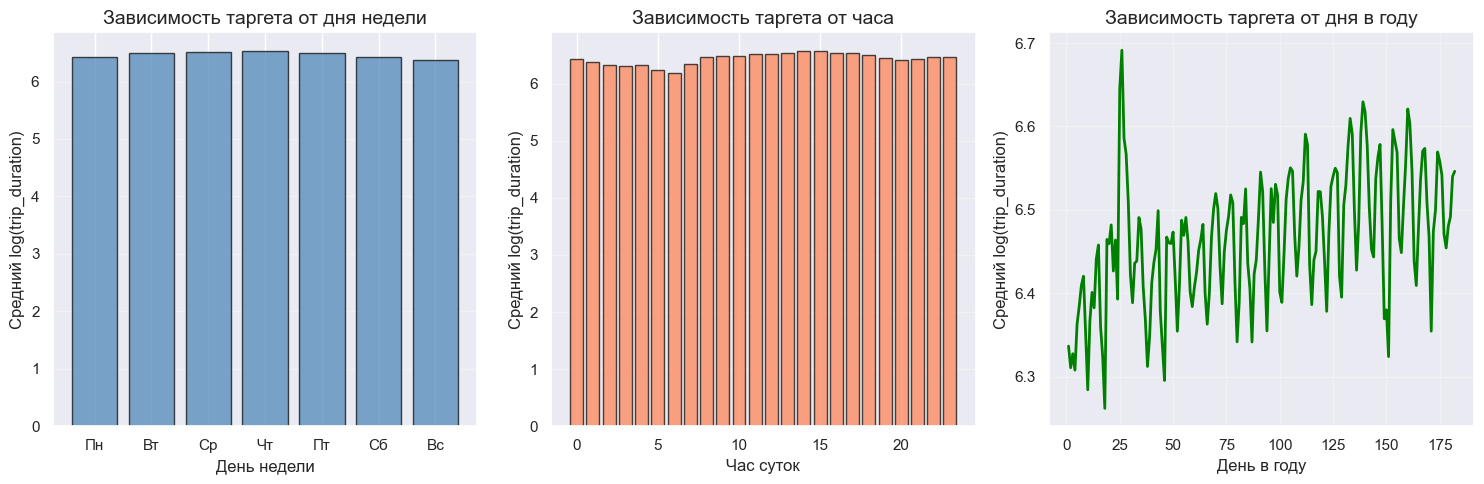

<Figure size 640x480 with 0 Axes>

In [18]:
# График зависимости среднего log_trip_duration от дня недели
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
weekday_means = train_df.groupby('day_of_week')['log_trip_duration'].mean()
plt.bar(range(7), weekday_means.values, edgecolor='black', alpha=0.7, color='steelblue')
plt.xticks(range(7), day_names)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от дня недели', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График зависимости от часа
plt.subplot(1, 3, 2)
hour_means = train_df.groupby('hour')['log_trip_duration'].mean()
plt.bar(hour_means.index, hour_means.values, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от часа', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График зависимости от дня в году
plt.subplot(1, 3, 3)
day_means = train_df.groupby('day_of_year')['log_trip_duration'].mean()
plt.plot(day_means.index, day_means.values, linewidth=2, color='green')
plt.xlabel('День в году', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от дня в году', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/target_dependency.png")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему?

**Ответ**: Графики не похожи, более того, они часто противоположны:
- Когда количество поездок минимально (ночные часы 3-5), средняя длительность МАКСИМАЛЬНА
- Когда количество поездок максимально (час пик), средняя длительность ниже

Это объясняется загруженностью дорог: в час пик много поездок, но они короче из-за пробок и низкой скорости. Ночью поездок мало, но те, что есть, длиннее из-за свободных дорог и более дальних направлений.

**Что происходит в аномальные периоды**: В дни снежной бури (23-24 января) средняя длительность резко возрастает - люди ездили только по необходимости, на дальние расстояния, при плохих дорожных условиях.

**Тренд по дням года**: Наблюдается небольшой рост средней длительности от начала года к середине, что может быть связано с улучшением погодных условий и увеличением дальних поездок.

In [19]:
# Создаем признаки на основе времени
# Определяем аномальные периоды
train_df['is_blizzard'] = ((train_df['day_of_year'] >= 23) &
                            (train_df['day_of_year'] <= 25)).astype(int)
test_df['is_blizzard'] = ((test_df['day_of_year'] >= 23) &
                           (test_df['day_of_year'] <= 25)).astype(int)

# Новогодние праздники
train_df['is_new_year'] = ((train_df['day_of_year'] >= 1) &
                            (train_df['day_of_year'] <= 3)).astype(int)
test_df['is_new_year'] = ((test_df['day_of_year'] >= 1) &
                           (test_df['day_of_year'] <= 3)).astype(int)

print("Добавлены признаки аномальных периодов")
print(f"Количество поездок во время снежной бури: {train_df['is_blizzard'].sum()}")
print(f"Количество поездок в новогодние праздники: {train_df['is_new_year'].sum()}")

Добавлены признаки аномальных периодов
Количество поездок во время снежной бури: 7828
Количество поездок в новогодние праздники: 14034


**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные?

**Ответ**:
- **Категориальные**: `day_of_week`, `month`, `hour` - это циклические категории без естественного порядка величин.
- **Численные**: `day_of_year` - имеет линейный тренд, `is_blizzard`, `is_new_year` - бинарные признаки.

Категориальные признаки лучше кодировать через One-Hot Encoding, чтобы модель не предполагала линейную зависимость.

### Задание 5: Первая модель

In [20]:
# Создаем список признаков
categorical_features = ['day_of_week', 'month', 'hour']
numerical_features = ['day_of_year', 'is_blizzard', 'is_new_year']

# Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Создаем pipeline
model_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель
X_train = train_df[categorical_features + numerical_features]
y_train = train_df['log_trip_duration']
X_test = test_df[categorical_features + numerical_features]
y_test = test_df['log_trip_duration']

model_1.fit(X_train, y_train)

# Предсказания
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

# Оценка качества
rmsle_train_1 = rmsle(y_train, y_pred_train)
rmsle_test_1 = rmsle(y_test, y_pred_test)

print("=" * 50)
print("Модель 1: Признаки на основе времени")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_1:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_1:.5f}")
print(f"Улучшение по сравнению с константой: {(rmsle_best_const - rmsle_test_1) / rmsle_best_const * 100:.2f}%")

Модель 1: Признаки на основе времени
RMSLE на обучающей выборке: 0.78901
RMSLE на тестовой выборке: 0.78807
Улучшение по сравнению с константой: 0.97%


# Часть 2. Изучаем координаты

Функция которая на карте рисует точки начала или конца поездки

In [21]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [22]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [23]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос:** Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?
**Ответ:**
- JFK Airport (Аэропорт Кеннеди): Четко видно изолированное скопление точек, отделенное от основной массы. Один из крупнейших аэропортов мира с постоянным потоком такси.
- LaGuardia Airport (Аэропорт Ла Гуардия): Видно отдельное скопление севернее центрального массива. Второй крупный аэропорт, обслуживающий в основном внутренние рейсы.
- Penn Station / Центральный Манхэттен: Максимальная плотность точек - виден почти сплошной синий массив. Penn Station - крупнейший ж/д вокзал, деловой и туристический центр.

Почему эти признаки полезны для модели? Разная средняя длительность:
1. JFK: ~45-60 минут
2. LaGuardia: ~30-40 минут
3. Penn Station (внутри города): ~10-20 минут
Разные паттерны трафика: Аэропорты меньше зависят от rush hour (едут по хайвеям), центр города сильно зависит от времени суток. Улучшение предсказаний: Эти бинарные признаки помогают модели "понять", что поездка из определенной локации имеет специфичное распределение длительности.

## Задание 6: Расстояние Haversine

In [24]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на Земле используя формулу Haversine
    Возвращает расстояние в километрах
    """
    # Радиус Земли в километрах
    R = 6371.0

    # Переводим градусы в радианы
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Разница координат
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Формула Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

In [25]:
# Вычисляем расстояние для train и test
train_df['haversine'] = haversine_distance(
    train_df['pickup_latitude'], train_df['pickup_longitude'],
    train_df['dropoff_latitude'], train_df['dropoff_longitude']
)

test_df['haversine'] = haversine_distance(
    test_df['pickup_latitude'], test_df['pickup_longitude'],
    test_df['dropoff_latitude'], test_df['dropoff_longitude']
)

In [26]:
# Добавляем логарифм расстояния
train_df['log_haversine'] = np.log1p(train_df['haversine'])
test_df['log_haversine'] = np.log1p(test_df['haversine'])

print(f"Статистика по расстоянию Haversine:")
print(train_df['haversine'].describe())
print(f"Статистика по log(haversine):")
print(train_df['log_haversine'].describe())

Статистика по расстоянию Haversine:
count    1.021050e+06
mean     3.443973e+00
std      4.361104e+00
min      0.000000e+00
25%      1.231736e+00
50%      2.095418e+00
75%      3.879408e+00
max      1.240909e+03
Name: haversine, dtype: float64
Статистика по log(haversine):
count    1.021050e+06
mean     1.255125e+00
std      6.273159e-01
min      0.000000e+00
25%      8.027797e-01
50%      1.129923e+00
75%      1.585024e+00
max      7.124405e+00
Name: log_haversine, dtype: float64


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [27]:
corr_haversine = train_df['haversine'].corr(train_df['log_trip_duration'])
corr_log_haversine = train_df['log_haversine'].corr(train_df['log_trip_duration'])

print(f"Корреляция haversine с таргетом: {corr_haversine:.4f}")
print(f"Корреляция log_haversine с таргетом: {corr_log_haversine:.4f}")

assert train_df['log_haversine'].corr(train_df['log_trip_duration']) > train_df['haversine'].corr(train_df['log_trip_duration'])

Корреляция haversine с таргетом: 0.5654
Корреляция log_haversine с таргетом: 0.7500


## Задание 7: Анализ скорости

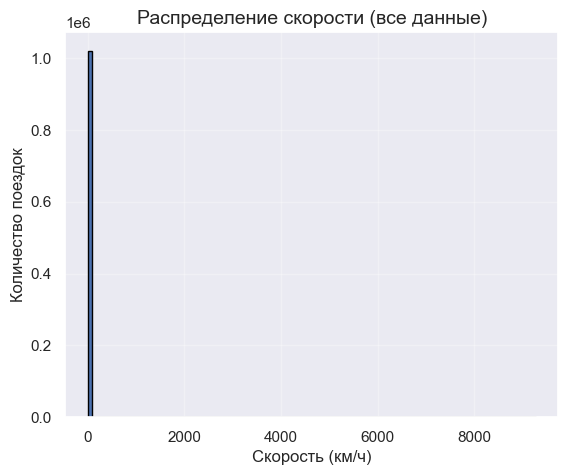

In [28]:
# Вычисляем скорость (км/ч)
train_df_with_speed = train_df.copy()
# Переводим секунды в часы
train_df_with_speed['speed'] = train_df_with_speed['haversine'] / (np.expm1(train_df_with_speed['log_trip_duration']) / 3600)

# Гистограмма всех скоростей
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(train_df_with_speed['speed'], bins=100, edgecolor='black')
plt.xlabel('Скорость (км/ч)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение скорости (все данные)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig("data/output/laboratory_work2/speed_distribution_all.png")

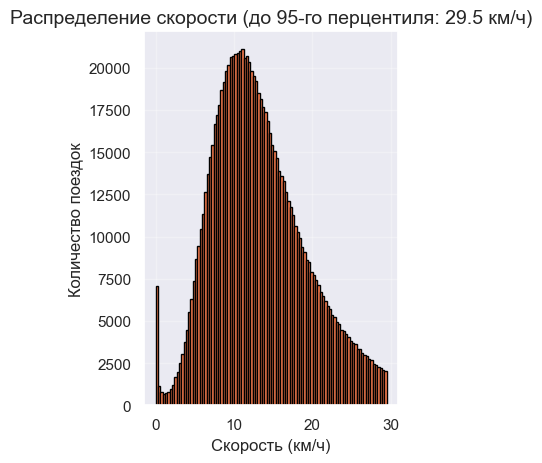

Статистика по скорости: count    1.021050e+06
mean     1.443489e+01
std      1.559053e+01
min      0.000000e+00
25%      9.128732e+00
50%      1.279986e+01
75%      1.785195e+01
max      9.274837e+03
Name: speed, dtype: float64


<Figure size 640x480 with 0 Axes>

In [29]:
# Гистограмма разумных скоростей (до 95-го перцентиля)
plt.subplot(1, 2, 2)
speed_95 = train_df_with_speed['speed'].quantile(0.95)
reasonable_speeds = train_df_with_speed[train_df_with_speed['speed'] <= speed_95]['speed']
plt.hist(reasonable_speeds, bins=100, edgecolor='black', color='coral')
plt.xlabel('Скорость (км/ч)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title(f'Распределение скорости (до 95-го перцентиля: {speed_95:.1f} км/ч)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/speed_distribution_reasonable.png")

print(f"Статистика по скорости: {train_df_with_speed['speed'].describe()}")

Медиана скоростей по дням недели и часам:

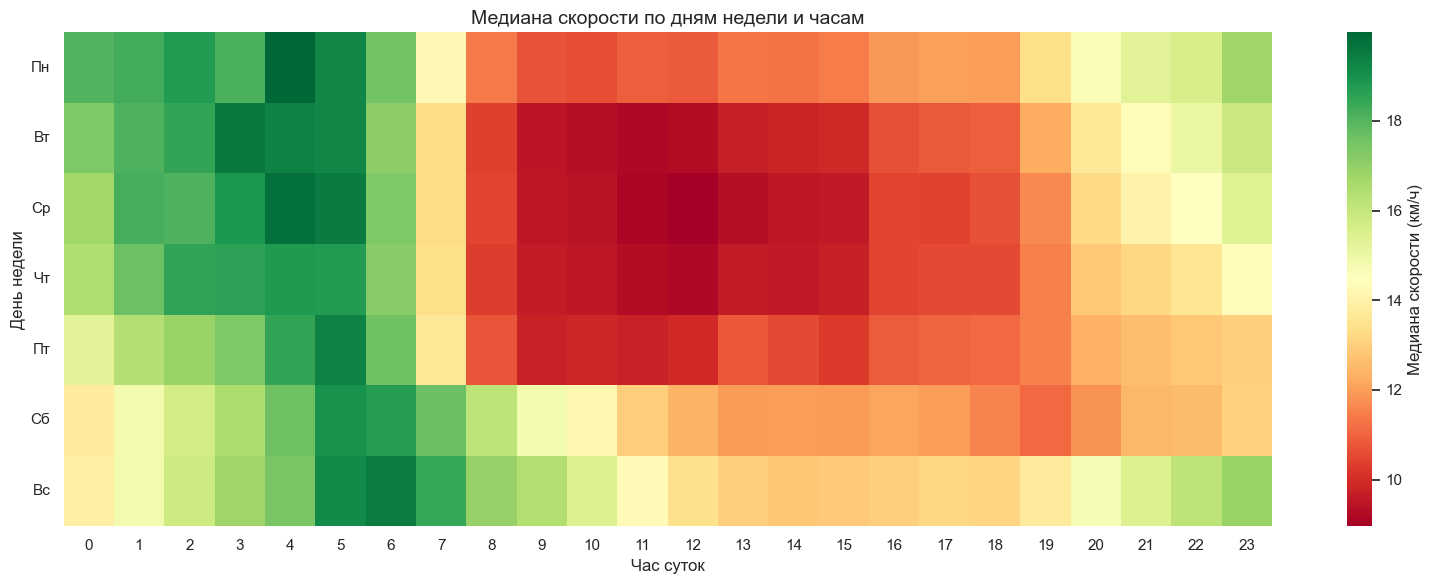

<Figure size 640x480 with 0 Axes>

In [30]:
# Вычисляем медиану скоростей для каждой пары (день недели, час)
speed_heatmap = train_df_with_speed[train_df_with_speed['speed'] <= speed_95].groupby(
    ['day_of_week', 'hour'])['speed'].median().reset_index()

# Создаем pivot таблицу для heatmap
speed_pivot = speed_heatmap.pivot(index='day_of_week', columns='hour', values='speed')

# Рисуем heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(speed_pivot, annot=False, cmap='RdYlGn', cbar_kws={'label': 'Медиана скорости (км/ч)'})
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('День недели', fontsize=12)
plt.yticks(np.arange(7) + 0.5, ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)
plt.title('Медиана скорости по дням недели и часам', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/speed_heatmap.png")

**Вопрос:** Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Скорость вычисляется как расстояние / время, где время - это наша целевая переменная (trip_duration). Использование скорости означало бы использование информации о целевой переменной. На тестовых данных у нас не будет значения trip_duration, поэтому мы не сможем вычислить скорость.

**Вопрос**: В какие моменты времени скорость минимальна/максимальна?

**Ответ**:
- **Минимальная скорость**: в будние дни (Пн-Пт) в утренние часы (7-9) и вечерние часы (17-19) - час пик, пробки
- **Максимальная скорость**: ночные и ранние утренние часы (0-5), а также выходные дни - свободные дороги

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог":

In [31]:
# Создаем признаки на основе анализа скорости
# Период пробок: будни 7-9 и 17-19
train_df['is_rush_hour'] = (
    (train_df['day_of_week'] < 5) &  # Будние дни
    (((train_df['hour'] >= 7) & (train_df['hour'] <= 9)) |
     ((train_df['hour'] >= 17) & (train_df['hour'] <= 19)))
).astype(int)

test_df['is_rush_hour'] = (
    (test_df['day_of_week'] < 5) &
    (((test_df['hour'] >= 7) & (test_df['hour'] <= 9)) |
     ((test_df['hour'] >= 17) & (test_df['hour'] <= 19)))
).astype(int)

# Период свободных дорог: ночные часы 0-5
train_df['is_free_traffic'] = ((train_df['hour'] >= 0) & (train_df['hour'] <= 5)).astype(int)
test_df['is_free_traffic'] = ((test_df['hour'] >= 0) & (test_df['hour'] <= 5)).astype(int)

print(f"Поездок в час пик: {train_df['is_rush_hour'].sum()} ({train_df['is_rush_hour'].mean()*100:.1f}%)")
print(f"Поездок в период свободных дорог: {train_df['is_free_traffic'].sum()} ({train_df['is_free_traffic'].mean()*100:.1f}%)")

Поездок в час пик: 243927 (23.9%)
Поездок в период свободных дорог: 120166 (11.8%)


## Задание 8: Признаки важных точек

Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:

- Началась ли поездка в этом пункте
- Закончилась ли поездка в этом пункте


**Важные точки на карте Манхэттена:**
1. **JFK Airport** (аэропорт): 40.6413, -73.7781
2. **LaGuardia Airport** (аэропорт): 40.7769, -73.8740
3. **Penn Station** (вокзал): 40.7505, -73.9934

In [32]:
# Функция для проверки близости к точке
def is_near_location(lat, lon, target_lat, target_lon, threshold_km=0.5):
    """Проверяет, находится ли точка в пределах threshold_km от целевой точки"""
    dist = haversine_distance(lat, lon, target_lat, target_lon)
    return (dist <= threshold_km).astype(int)

In [33]:
# JFK Airport
jfk_lat, jfk_lon = 40.6413, -73.7781
train_df['pickup_jfk'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], jfk_lat, jfk_lon)
train_df['dropoff_jfk'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], jfk_lat, jfk_lon)
test_df['pickup_jfk'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], jfk_lat, jfk_lon)
test_df['dropoff_jfk'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], jfk_lat, jfk_lon)

In [34]:
# LaGuardia Airport
lga_lat, lga_lon = 40.7769, -73.8740
train_df['pickup_lga'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], lga_lat, lga_lon)
train_df['dropoff_lga'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], lga_lat, lga_lon)
test_df['pickup_lga'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], lga_lat, lga_lon)
test_df['dropoff_lga'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], lga_lat, lga_lon)

In [35]:
# Penn Station
penn_lat, penn_lon = 40.7505, -73.9934
train_df['pickup_penn'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], penn_lat, penn_lon)
train_df['dropoff_penn'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], penn_lat, penn_lon)
test_df['pickup_penn'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], penn_lat, penn_lon)
test_df['dropoff_penn'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], penn_lat, penn_lon)

In [36]:
print("Добавлены признаки важных точек:")
print(f"JFK - начало: {train_df['pickup_jfk'].sum()}, конец: {train_df['dropoff_jfk'].sum()}")
print(f"LaGuardia - начало: {train_df['pickup_lga'].sum()}, конец: {train_df['dropoff_lga'].sum()}")
print(f"Penn Station - начало: {train_df['pickup_penn'].sum()}, конец: {train_df['dropoff_penn'].sum()}")

Добавлены признаки важных точек:
JFK - начало: 6853, конец: 1845
LaGuardia - начало: 13488, конец: 6379
Penn Station - начало: 48788, конец: 40859


**Почему эти признаки могут быть полезны:**
- Аэропорты - это специфические поездки с предсказуемой длительностью
- Вокзалы - важные транспортные узлы с большим потоком пассажиров

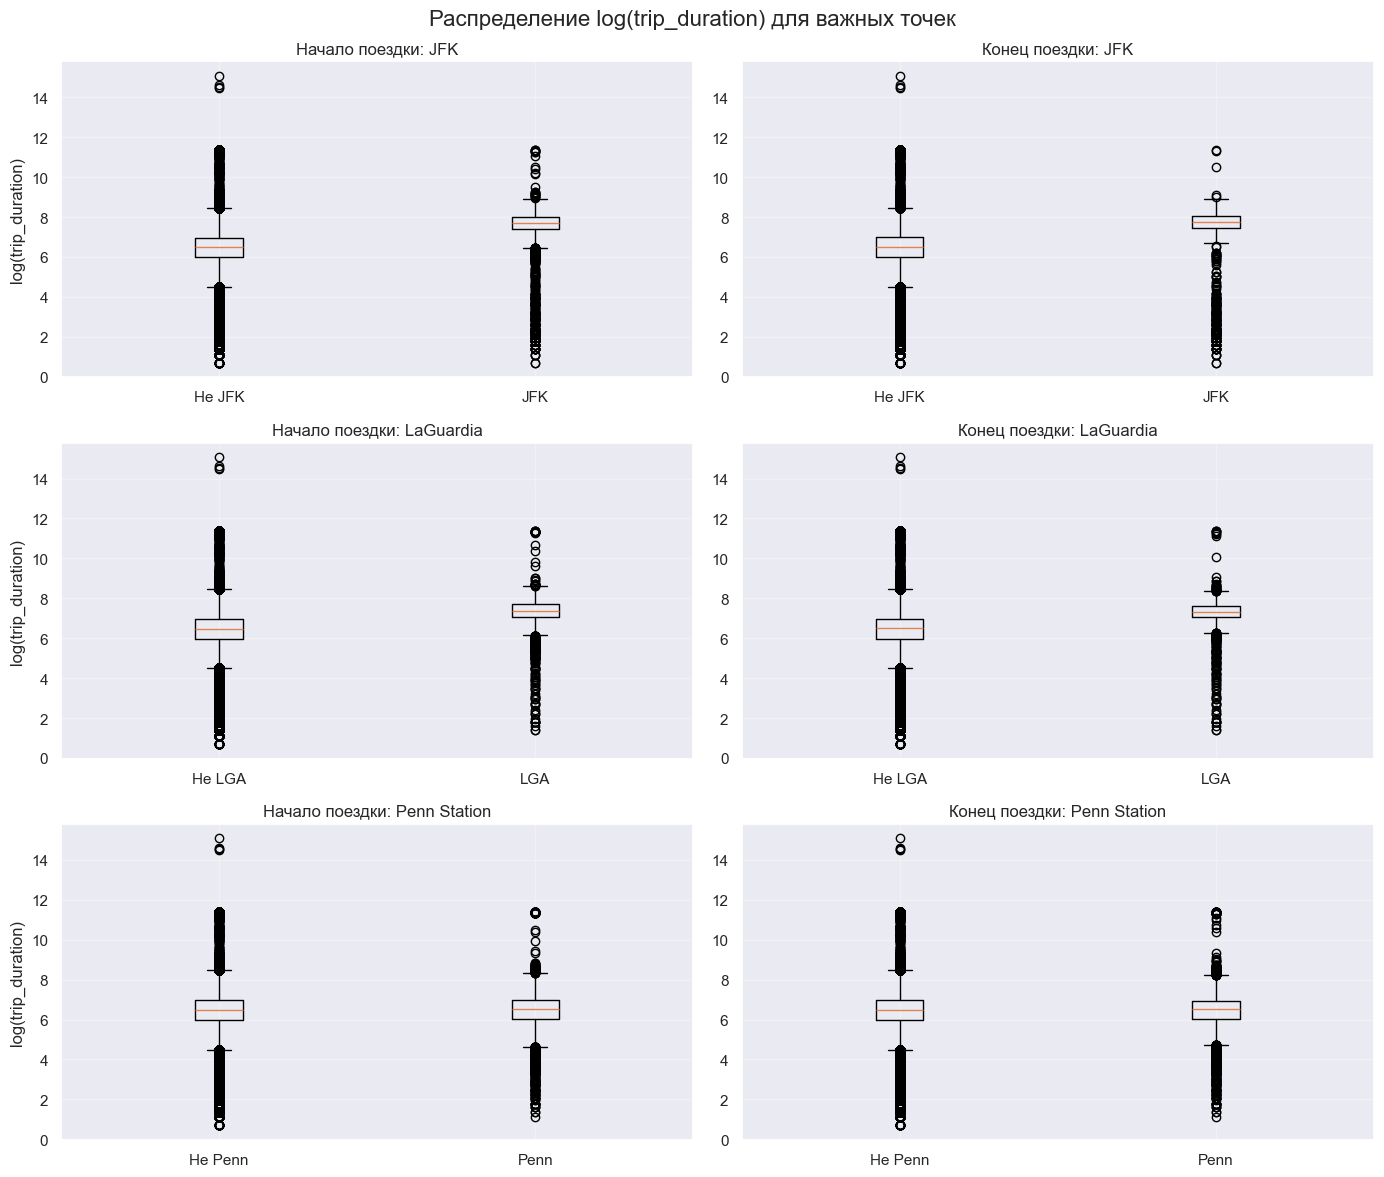

<Figure size 640x480 with 0 Axes>

In [37]:
# Визуализируем распределение таргета для каждого признака
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Распределение log(trip_duration) для важных точек', fontsize=16)

# JFK
axes[0, 0].boxplot([train_df[train_df['pickup_jfk']==0]['log_trip_duration'],
                     train_df[train_df['pickup_jfk']==1]['log_trip_duration']],
                    labels=['Не JFK', 'JFK'])
axes[0, 0].set_title('Начало поездки: JFK')
axes[0, 0].set_ylabel('log(trip_duration)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([train_df[train_df['dropoff_jfk']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_jfk']==1]['log_trip_duration']],
                    labels=['Не JFK', 'JFK'])
axes[0, 1].set_title('Конец поездки: JFK')
axes[0, 1].grid(True, alpha=0.3)

# LaGuardia
axes[1, 0].boxplot([train_df[train_df['pickup_lga']==0]['log_trip_duration'],
                     train_df[train_df['pickup_lga']==1]['log_trip_duration']],
                    labels=['Не LGA', 'LGA'])
axes[1, 0].set_title('Начало поездки: LaGuardia')
axes[1, 0].set_ylabel('log(trip_duration)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot([train_df[train_df['dropoff_lga']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_lga']==1]['log_trip_duration']],
                    labels=['Не LGA', 'LGA'])
axes[1, 1].set_title('Конец поездки: LaGuardia')
axes[1, 1].grid(True, alpha=0.3)

# Penn Station
axes[2, 0].boxplot([train_df[train_df['pickup_penn']==0]['log_trip_duration'],
                     train_df[train_df['pickup_penn']==1]['log_trip_duration']],
                    labels=['Не Penn', 'Penn'])
axes[2, 0].set_title('Начало поездки: Penn Station')
axes[2, 0].set_ylabel('log(trip_duration)')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].boxplot([train_df[train_df['dropoff_penn']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_penn']==1]['log_trip_duration']],
                    labels=['Не Penn', 'Penn'])
axes[2, 1].set_title('Конец поездки: Penn Station')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/important_locations_distribution.png")

**Вопрос**: Судя по графикам, хорошими ли получились эти признаки?

**Ответ**: Да, признаки получились хорошими! Для JFK и LaGuardia видно, что медиана длительности поездки значительно выше, что логично - аэропорты находятся дальше от центра. Penn Station показывает меньшую разницу, но признак все равно полезен.

## Задание 9: MapGridTransformer

In [38]:
class MapGridTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для создания признаков на основе разбиения карты на ячейки
    """
    def __init__(self, n_rows=20, n_cols=20):
        self.n_rows = n_rows
        self.n_cols = n_cols
        # Границы области Манхэттена
        self.lat_min = 40.6
        self.lat_max = 40.9
        self.lon_min = -74.05
        self.lon_max = -73.75

    def fit(self, X, y=None):
        # Вычисляем размеры ячеек
        self.lat_step = (self.lat_max - self.lat_min) / self.n_rows
        self.lon_step = (self.lon_max - self.lon_min) / self.n_cols
        return self

    def _get_cell_id(self, lat, lon):
        """Возвращает номер ячейки для координат"""
        # Проверяем, попадают ли координаты в область
        mask = ((lat >= self.lat_min) & (lat <= self.lat_max) &
                (lon >= self.lon_min) & (lon <= self.lon_max))

        # Вычисляем индексы строки и столбца
        row_idx = ((lat - self.lat_min) / self.lat_step).astype(int)
        col_idx = ((lon - self.lon_min) / self.lon_step).astype(int)

        # Ограничиваем индексы
        row_idx = np.clip(row_idx, 0, self.n_rows - 1)
        col_idx = np.clip(col_idx, 0, self.n_cols - 1)

        # Вычисляем ID ячейки
        cell_id = row_idx * self.n_cols + col_idx

        # Устанавливаем -1 для точек вне области
        cell_id = np.where(mask, cell_id, -1)

        return cell_id

    def transform(self, X, y=None):
        """Добавляет признаки номеров ячеек для начала и конца поездки"""
        X_copy = X.copy()

        X_copy['pickup_cell'] = self._get_cell_id(
            X_copy['pickup_latitude'].values,
            X_copy['pickup_longitude'].values
        )

        X_copy['dropoff_cell'] = self._get_cell_id(
            X_copy['dropoff_latitude'].values,
            X_copy['dropoff_longitude'].values
        )

        return X_copy

    def show_map(self, data_sample):
        """Визуализирует разбиение на ячейки"""
        m = folium.Map(
            location=[(self.lat_min + self.lat_max)/2, (self.lon_min + self.lon_max)/2],
            zoom_start=11
        )

        # Рисуем сетку
        for i in range(self.n_rows + 1):
            lat = self.lat_min + i * self.lat_step
            folium.PolyLine(
                locations=[[lat, self.lon_min], [lat, self.lon_max]],
                color='blue',
                weight=1,
                opacity=0.5
            ).add_to(m)

        for j in range(self.n_cols + 1):
            lon = self.lon_min + j * self.lon_step
            folium.PolyLine(
                locations=[[self.lat_min, lon], [self.lat_max, lon]],
                color='blue',
                weight=1,
                opacity=0.5
            ).add_to(m)

        return m

In [39]:
# Применяем трансформер
grid_transformer = MapGridTransformer(n_rows=20, n_cols=20)
grid_transformer.fit(train_df)

train_df = grid_transformer.transform(train_df)
test_df = grid_transformer.transform(test_df)

print("Добавлены признаки ячеек:")
print(f"Уникальных ячеек для начала: {train_df['pickup_cell'].nunique()}")
print(f"Уникальных ячеек для конца: {train_df['dropoff_cell'].nunique()}")
print(f"Поездок вне области (pickup): {(train_df['pickup_cell'] == -1).sum()}")
print(f"Поездок вне области (dropoff): {(train_df['dropoff_cell'] == -1).sum()}")

Добавлены признаки ячеек:
Уникальных ячеек для начала: 306
Уникальных ячеек для конца: 354
Поездок вне области (pickup): 585
Поездок вне области (dropoff): 5067


## Задание 10: Модель с координатными признаками

In [40]:
# Обновляем списки признаков
categorical_features_2 = ['day_of_week', 'month', 'hour', 'pickup_cell', 'dropoff_cell']
numerical_features_2 = [
    'day_of_year', 'is_blizzard', 'is_new_year',
    'log_haversine', 'is_rush_hour', 'is_free_traffic',
    'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga',
    'pickup_penn', 'dropoff_penn'
]

In [41]:
# Создаем препроцессор
preprocessor_2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_2),
        (
            "cat",
            OneHotEncoder(
                drop="first",
                sparse_output=True,
                handle_unknown="ignore",
            ),
            categorical_features_2,
        ),
    ],
    sparse_threshold=0.3
)

In [42]:
# Создаем и обучаем модель
model_2 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('regressor', Ridge())
])

X_train_2 = train_df[categorical_features_2 + numerical_features_2]
X_test_2 = test_df[categorical_features_2 + numerical_features_2]

model_2.fit(X_train_2, y_train)

y_pred_train_2 = model_2.predict(X_train_2)
y_pred_test_2 = model_2.predict(X_test_2)

rmsle_train_2 = rmsle(y_train, y_pred_train_2)
rmsle_test_2 = rmsle(y_test, y_pred_test_2)

print("=" * 50)
print("Модель 2: С признаками координат")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_2:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_2:.5f}")
print(f"Улучшение по сравнению с Моделью 1: {(rmsle_test_1 - rmsle_test_2) / rmsle_test_1 * 100:.2f}%")

Модель 2: С признаками координат
RMSLE на обучающей выборке: 0.47008
RMSLE на тестовой выборке: 0.47011
Улучшение по сравнению с Моделью 1: 40.35%


# Часть 3. Изучаем оставшиеся признаки

## Задание 11: Анализ vendor_id, passenger_count, store_and_fwd_flag

In [43]:
# Проверяем уникальные значения
print("Уникальные значения признаков:")
print(
    f"vendor_id: {train_df['vendor_id'].nunique()} - {train_df['vendor_id'].unique()}"
)
print(
    f"passenger_count: {train_df['passenger_count'].nunique()} - {sorted(train_df['passenger_count'].unique())}"
)
print(
    f"store_and_fwd_flag: {train_df['store_and_fwd_flag'].nunique()} - {train_df['store_and_fwd_flag'].unique()}"
)

Уникальные значения признаков:
vendor_id: 2 - [2 1]
passenger_count: 10 - [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
store_and_fwd_flag: 2 - ['N' 'Y']


**Вопрос**: Почему каждый из этих признаков может быть потенциально полезным?

**Ответ**:
- **vendor_id**: Разные компании могут иметь разные маршруты, стратегии вождения, или типы автомобилей
- **passenger_count**: Больше пассажиров может означать больше остановок для посадки/высадки, или поездки в разные районы
- **store_and_fwd_flag**: Этот флаг указывает, что данные не могли быть отправлены сразу (проблемы со связью). Это может коррелировать с определенными районами или погодными условиями

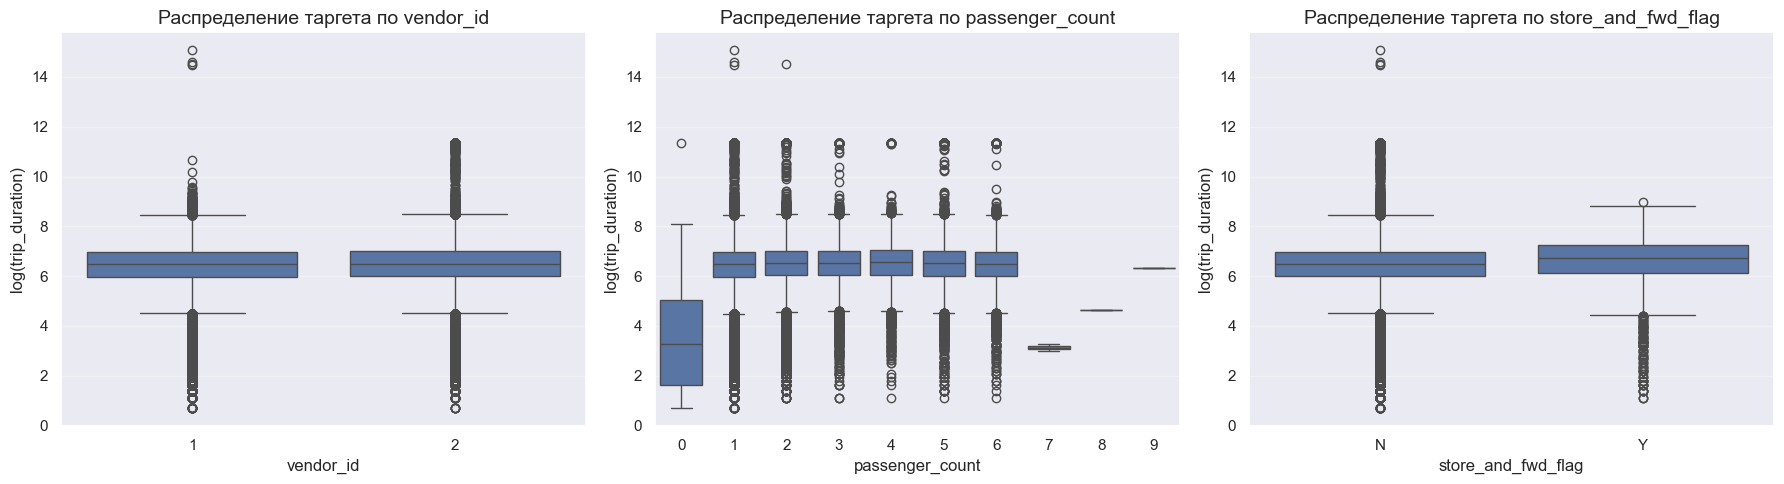

<Figure size 640x480 with 0 Axes>

In [44]:
# Визуализируем распределения
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# vendor_id
sns.boxplot(data=train_df, x="vendor_id", y="log_trip_duration", ax=axes[0])
axes[0].set_title("Распределение таргета по vendor_id", fontsize=14)
axes[0].set_ylabel("log(trip_duration)", fontsize=12)
axes[0].grid(True, alpha=0.3, axis="y")

# passenger_count
sns.boxplot(data=train_df, x="passenger_count", y="log_trip_duration", ax=axes[1])
axes[1].set_title("Распределение таргета по passenger_count", fontsize=14)
axes[1].set_ylabel("log(trip_duration)", fontsize=12)
axes[1].grid(True, alpha=0.3, axis="y")

# store_and_fwd_flag
sns.boxplot(data=train_df, x="store_and_fwd_flag", y="log_trip_duration", ax=axes[2])
axes[2].set_title("Распределение таргета по store_and_fwd_flag", fontsize=14)
axes[2].set_ylabel("log(trip_duration)", fontsize=12)
axes[2].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/categorical_features_distribution.png")

In [45]:
# Преобразуем в бинарные признаки
# vendor_id: 1 -> 0, 2 -> 1
train_df["vendor_binary"] = (train_df["vendor_id"] == 2).astype(int)
test_df["vendor_binary"] = (test_df["vendor_id"] == 2).astype(int)

# store_and_fwd_flag: N -> 0, Y -> 1
train_df["store_fwd_binary"] = (train_df["store_and_fwd_flag"] == "Y").astype(int)
test_df["store_fwd_binary"] = (test_df["store_and_fwd_flag"] == "Y").astype(int)

print("Преобразованы признаки в бинарные")

Преобразованы признаки в бинарные


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: 
- **vendor_id**: Разница небольшая, но есть - vendor 2 имеет чуть большую среднюю длительность
- **passenger_count**: Незначительная разница, но видно, что 6 пассажиров - аномалия (мало данных)
- **store_and_fwd_flag**: Очень мало поездок с флагом Y, но они показывают большую длительность

В целом, признаки слабые, но могут дать небольшое улучшение.

## Задание 12: Модель со всеми признаками

In [46]:
# Обновляем списки признаков
categorical_features_3 = [
    "day_of_week",
    "month",
    "hour",
    "pickup_cell",
    "dropoff_cell",
    "passenger_count",
]
numerical_features_3 = numerical_features_2 + ["vendor_binary", "store_fwd_binary"]

In [47]:
# Создаем и обучаем модель
preprocessor_3 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_3),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            categorical_features_3,
        ),
    ]
)

model_3 = Pipeline([("preprocessor", preprocessor_3), ("regressor", Ridge())])

X_train_3 = train_df[categorical_features_3 + numerical_features_3]
X_test_3 = test_df[categorical_features_3 + numerical_features_3]

model_3.fit(X_train_3, y_train)

y_pred_train_3 = model_3.predict(X_train_3)
y_pred_test_3 = model_3.predict(X_test_3)

rmsle_train_3 = rmsle(y_train, y_pred_train_3)
rmsle_test_3 = rmsle(y_test, y_pred_test_3)

print("=" * 50)
print("Модель 3: Со всеми признаками")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_3:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_3:.5f}")
print(
    f"Улучшение по сравнению с Моделью 2: {(rmsle_test_2 - rmsle_test_3) / rmsle_test_2 * 100:.2f}%"
)

Модель 3: Со всеми признаками
RMSLE на обучающей выборке: 0.46958
RMSLE на тестовой выборке: 0.46971
Улучшение по сравнению с Моделью 2: 0.08%


 # Часть 4. Улучшаем модель

## Задание 13: Удаление выбросов

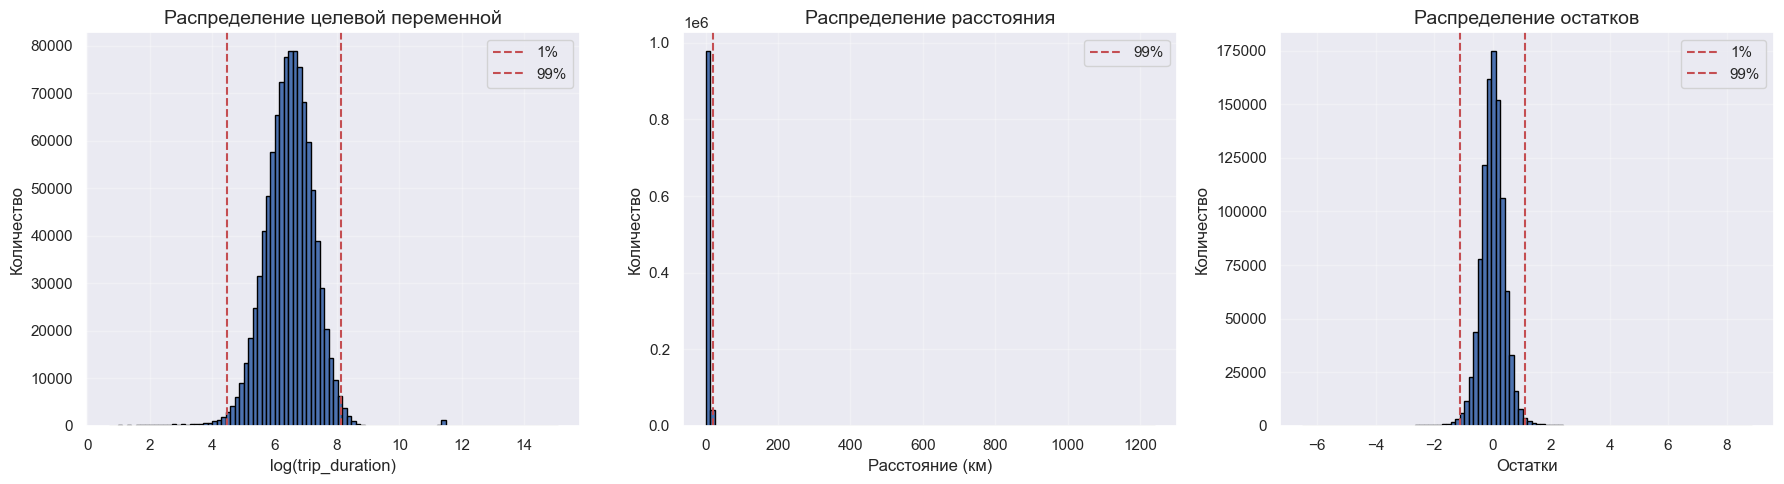

Статистика до удаления выбросов:
Размер обучающей выборки: 1021050


<Figure size 640x480 with 0 Axes>

In [48]:
# Визуализируем распределения для поиска выбросов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение log_trip_duration
axes[0].hist(train_df["log_trip_duration"], bins=100, edgecolor="black")
axes[0].set_xlabel("log(trip_duration)", fontsize=12)
axes[0].set_ylabel("Количество", fontsize=12)
axes[0].set_title("Распределение целевой переменной", fontsize=14)
axes[0].axvline(
    train_df["log_trip_duration"].quantile(0.01), color="r", linestyle="--", label="1%"
)
axes[0].axvline(
    train_df["log_trip_duration"].quantile(0.99), color="r", linestyle="--", label="99%"
)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Распределение haversine
axes[1].hist(train_df["haversine"], bins=100, edgecolor="black")
axes[1].set_xlabel("Расстояние (км)", fontsize=12)
axes[1].set_ylabel("Количество", fontsize=12)
axes[1].set_title("Распределение расстояния", fontsize=14)
axes[1].axvline(
    train_df["haversine"].quantile(0.99), color="r", linestyle="--", label="99%"
)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Распределение остатков модели 3
residuals = y_train - y_pred_train_3
axes[2].hist(residuals, bins=100, edgecolor="black")
axes[2].set_xlabel("Остатки", fontsize=12)
axes[2].set_ylabel("Количество", fontsize=12)
axes[2].set_title("Распределение остатков", fontsize=14)
axes[2].axvline(np.percentile(residuals, 1), color="r", linestyle="--", label="1%")
axes[2].axvline(np.percentile(residuals, 99), color="r", linestyle="--", label="99%")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/outliers_detection.png")

# Определяем выбросы
print("Статистика до удаления выбросов:")
print(f"Размер обучающей выборки: {len(train_df)}")

In [49]:
# Удаляем выбросы
# 1. Очень короткие поездки (меньше 1-го перцентиля)
# 2. Очень длинные поездки (больше 99-го перцентиля)
# 3. Очень большие расстояния (больше 99-го перцентиля)
# 4. Очень маленькие расстояния при большом времени

train_df_clean = train_df[
    (train_df["log_trip_duration"] > train_df["log_trip_duration"].quantile(0.01))
    & (train_df["log_trip_duration"] < train_df["log_trip_duration"].quantile(0.99))
    & (train_df["haversine"] < train_df["haversine"].quantile(0.99))
    & (train_df["haversine"] > 0.1)  # Минимальное расстояние 100 метров
].copy()

print(f"\nСтатистика после удаления выбросов:")
print(f"Размер обучающей выборки: {len(train_df_clean)}")
print(
    f"Удалено выбросов: {len(train_df) - len(train_df_clean)} ({(len(train_df) - len(train_df_clean))/len(train_df)*100:.2f}%)"
)


Статистика после удаления выбросов:
Размер обучающей выборки: 988584
Удалено выбросов: 32466 (3.18%)


In [50]:
# Обновляем y_train
y_train_clean = train_df_clean["log_trip_duration"]

In [51]:
# Объединяем редкие категории для категориальных признаков
# Для pickup_cell и dropoff_cell оставляем только частые ячейки

def merge_rare_categories(df, column, threshold=100):
    """Объединяет редкие категории в одну"""
    value_counts = df[column].value_counts()
    rare_categories = value_counts[value_counts < threshold].index
    df[column] = df[column].apply(lambda x: -2 if x in rare_categories else x)
    return df

In [52]:
# Применяем к обучающей выборке
train_df_clean = merge_rare_categories(train_df_clean, "pickup_cell", threshold=50)
train_df_clean = merge_rare_categories(train_df_clean, "dropoff_cell", threshold=50)

print("Редкие категории объединены")
print(
    f"Уникальных ячеек pickup после фильтрации: {train_df_clean['pickup_cell'].nunique()}"
)
print(
    f"Уникальных ячеек dropoff после фильтрации: {train_df_clean['dropoff_cell'].nunique()}"
)

Редкие категории объединены
Уникальных ячеек pickup после фильтрации: 100
Уникальных ячеек dropoff после фильтрации: 209


In [53]:
valid_pickup_cells = set(train_df_clean["pickup_cell"].unique())
valid_dropoff_cells = set(train_df_clean["dropoff_cell"].unique())

# Применяем ту же логику к тестовой выборке
test_df["pickup_cell"] = test_df["pickup_cell"].where(
    test_df["pickup_cell"].isin(valid_pickup_cells), -2
)

test_df["dropoff_cell"] = test_df["dropoff_cell"].where(
    test_df["dropoff_cell"].isin(valid_dropoff_cells), -2
)

In [54]:
# Обучаем модель на очищенных данных
X_train_clean = train_df_clean[categorical_features_3 + numerical_features_3]

model_4 = Pipeline([("preprocessor", preprocessor_3), ("regressor", Ridge())])
model_4.fit(X_train_clean, y_train_clean)

y_pred_train_4 = model_4.predict(X_train_clean)
y_pred_test_4 = model_4.predict(X_test_3)

rmsle_train_4 = rmsle(y_train_clean, y_pred_train_4)
rmsle_test_4 = rmsle(y_test, y_pred_test_4)

In [55]:
print("=" * 50)
print("Модель 4: После удаления выбросов")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_4:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_4:.5f}")
print(
    f"Изменение по сравнению с Моделью 3: {(rmsle_test_3 - rmsle_test_4) / rmsle_test_3 * 100:.2f}%"
)

Модель 4: После удаления выбросов
RMSLE на обучающей выборке: 0.38219
RMSLE на тестовой выборке: 0.47134
Изменение по сравнению с Моделью 3: -0.35%


## Задание 14: Сравнение Ridge и Lasso

In [56]:
# Считаем количество признаков
X_transformed = preprocessor_3.fit_transform(X_train_clean)
print(
    f"Количество признаков до кодирования: {len(categorical_features_3 + numerical_features_3)}"
)
print(f"Количество признаков после OneHot-кодирования: {X_transformed.shape[1]}")

Количество признаков до кодирования: 20
Количество признаков после OneHot-кодирования: 362


In [57]:
from sklearn.linear_model import Lasso

# Берем случайную подвыборку для Lasso (30% данных)
sample_size = int(len(X_train_clean) * 0.3)
sample_indices = np.random.choice(len(X_train_clean), sample_size, replace=False)

X_train_sample = X_train_clean.iloc[sample_indices]
y_train_sample = y_train_clean.iloc[sample_indices]

print(f"Обучаем Lasso на подвыборке: {sample_size} строк...")

model_lasso = Pipeline(
    [
        ("preprocessor", preprocessor_3),
        (
            "regressor",
            Lasso(
                alpha=1.0,
                max_iter=5000,
                tol=1e-3,
                random_state=42,
                selection="random",
            ),
        ),
    ]
)

model_lasso.fit(X_train_sample, y_train_sample)
print("Обучение завершено!")

y_pred_lasso = model_lasso.predict(X_test_3)
rmsle_lasso = rmsle(y_test, y_pred_lasso)

print("\nСравнение Ridge и Lasso (Lasso на 30% данных):")
print(f"Ridge RMSLE: {rmsle_test_4:.5f}")
print(f"Lasso RMSLE: {rmsle_lasso:.5f}")
print(f"Лучше: {'Ridge' if rmsle_test_4 < rmsle_lasso else 'Lasso'}")

Обучаем Lasso на подвыборке: 296575 строк...
Обучение завершено!

Сравнение Ridge и Lasso (Lasso на 30% данных):
Ridge RMSLE: 0.47134
Lasso RMSLE: 0.79503
Лучше: Ridge


In [58]:
# Подбор параметра регуляризации
# Разбиваем обучающую выборку на train и validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_clean, y_train_clean, test_size=0.2, random_state=42
)

# Сетка параметров alpha (логарифмическая)
alphas = np.logspace(-3, 3, 20)

ridge_scores = []
lasso_scores = []
lasso_n_zeros = []

for alpha in alphas:
    # Ridge
    model_ridge_cv = Pipeline(
        [("preprocessor", preprocessor_3), ("regressor", Ridge(alpha=alpha))]
    )
    model_ridge_cv.fit(X_train_split, y_train_split)
    y_pred_val_ridge = model_ridge_cv.predict(X_val_split)
    ridge_scores.append(rmsle(y_val_split, y_pred_val_ridge))

    # Lasso
    model_lasso_cv = Pipeline(
        [
            ("preprocessor", preprocessor_3),
            ("regressor", Lasso(alpha=alpha, max_iter=10000)),
        ]
    )
    model_lasso_cv.fit(X_train_split, y_train_split)
    y_pred_val_lasso = model_lasso_cv.predict(X_val_split)
    lasso_scores.append(rmsle(y_val_split, y_pred_val_lasso))

    # Считаем количество нулевых весов в Lasso
    n_zeros = np.sum(model_lasso_cv.named_steps["regressor"].coef_ == 0)
    lasso_n_zeros.append(n_zeros)

# Находим оптимальные alpha
best_ridge_idx = np.argmin(ridge_scores)
best_lasso_idx = np.argmin(lasso_scores)

print(
    f"\\nЛучший alpha для Ridge: {alphas[best_ridge_idx]:.4f}, RMSLE: {ridge_scores[best_ridge_idx]:.5f}"
)
print(
    f"Лучший alpha для Lasso: {alphas[best_lasso_idx]:.4f}, RMSLE: {lasso_scores[best_lasso_idx]:.5f}"
)

\nЛучший alpha для Ridge: 6.1585, RMSLE: 0.38217
Лучший alpha для Lasso: 0.0010, RMSLE: 0.39349


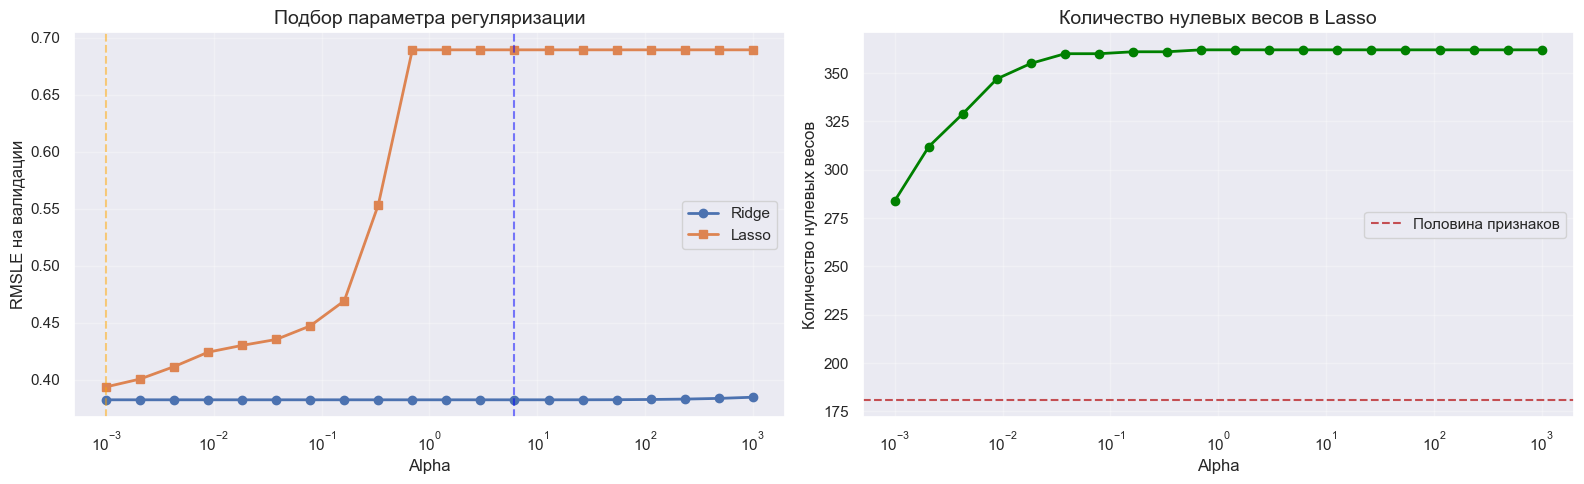


Для избавления от половины признаков нужен alpha=0.0010
При этом RMSLE = 0.39349
Потеря в качестве: 0.00%


<Figure size 640x480 with 0 Axes>

In [59]:
# Визуализируем результаты
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# График зависимости RMSLE от alpha
axes[0].plot(alphas, ridge_scores, "o-", label="Ridge", linewidth=2)
axes[0].plot(alphas, lasso_scores, "s-", label="Lasso", linewidth=2)
axes[0].axvline(alphas[best_ridge_idx], color="blue", linestyle="--", alpha=0.5)
axes[0].axvline(alphas[best_lasso_idx], color="orange", linestyle="--", alpha=0.5)
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha", fontsize=12)
axes[0].set_ylabel("RMSLE на валидации", fontsize=12)
axes[0].set_title("Подбор параметра регуляризации", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График количества нулевых весов в Lasso
axes[1].plot(alphas, lasso_n_zeros, "o-", color="green", linewidth=2)
axes[1].axhline(
    X_transformed.shape[1] / 2, color="r", linestyle="--", label="Половина признаков"
)
axes[1].set_xscale("log")
axes[1].set_xlabel("Alpha", fontsize=12)
axes[1].set_ylabel("Количество нулевых весов", fontsize=12)
axes[1].set_title("Количество нулевых весов в Lasso", fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/regularization_tuning.png")

# Находим alpha, при котором половина весов = 0
half_features = X_transformed.shape[1] / 2
idx_half = np.argmin(np.abs(np.array(lasso_n_zeros) - half_features))
print(f"\nДля избавления от половины признаков нужен alpha={alphas[idx_half]:.4f}")
print(f"При этом RMSLE = {lasso_scores[idx_half]:.5f}")
print(
    f"Потеря в качестве: {(lasso_scores[idx_half] - lasso_scores[best_lasso_idx]) / lasso_scores[best_lasso_idx] * 100:.2f}%"
)

In [60]:
# Обучаем финальную модель с лучшими параметрами
best_model_type = (
    "Ridge" if ridge_scores[best_ridge_idx] < lasso_scores[best_lasso_idx] else "Lasso"
)
best_alpha = (
    alphas[best_ridge_idx] if best_model_type == "Ridge" else alphas[best_lasso_idx]
)

if best_model_type == "Ridge":
    model_final = Pipeline(
        [("preprocessor", preprocessor_3), ("regressor", Ridge(alpha=best_alpha))]
    )
else:
    model_final = Pipeline(
        [
            ("preprocessor", preprocessor_3),
            ("regressor", Lasso(alpha=best_alpha, max_iter=10000)),
        ]
    )

model_final.fit(X_train_clean, y_train_clean)
y_pred_final = model_final.predict(X_test_3)
rmsle_final = rmsle(y_test, y_pred_final)

print("=" * 50)
print(f"Финальная модель: {best_model_type} (alpha={best_alpha:.4f})")
print("=" * 50)
print(f"RMSLE на тестовой выборке: {rmsle_final:.5f}")
print(
    f"Улучшение по сравнению с константой: {(rmsle_best_const - rmsle_final) / rmsle_best_const * 100:.2f}%"
)

Финальная модель: Ridge (alpha=6.1585)
RMSLE на тестовой выборке: 0.47133
Улучшение по сравнению с константой: 40.77%


## Задание 15: Feature Interactions

In [61]:
# Создаем признаки взаимодействия маршрутов
# Находим топ-100 самых частых пар (pickup_cell, dropoff_cell)

route_counts = train_df_clean.groupby(["pickup_cell", "dropoff_cell"]).size()
top_routes = route_counts.nlargest(100).index

print(
    f"Топ-100 маршрутов покрывают {route_counts.nlargest(100).sum() / len(train_df_clean) * 100:.1f}% поездок"
)


# Создаем признак "популярный маршрут"
def encode_route(row, top_routes):
    route = (row["pickup_cell"], row["dropoff_cell"])
    if route in top_routes:
        return f"route_{top_routes.get_loc(route)}"
    return "route_other"


train_df_clean["route"] = train_df_clean.apply(
    lambda row: encode_route(row, top_routes), axis=1
)
test_df["route"] = test_df.apply(lambda row: encode_route(row, top_routes), axis=1)

print(f"Создан признак 'route' с {train_df_clean['route'].nunique()} категориями")

Топ-100 маршрутов покрывают 55.4% поездок
Создан признак 'route' с 101 категориями


**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию?

**Ответ**: Линейная модель работает с признаками независимо. Если у нас есть признаки `pickup_cell=A` и `dropoff_cell=B`, модель учится весам `w1` для `A` и `w2` для `B`, и `предсказание = w1 + w2`. Но для маршрута `A→B` может быть уникальная длительность, которая не является просто суммой эффектов `A` и `B`.

In [62]:
# Обновляем признаки
categorical_features_final = categorical_features_3 + ["route"]
numerical_features_final = numerical_features_3

preprocessor_final = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_final),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            categorical_features_final,
        ),
    ]
)

# Обучаем модель с новыми признаками
model_with_routes = Pipeline(
    [
        ("preprocessor", preprocessor_final),
        (
            "regressor",
            (
                Ridge(alpha=best_alpha)
                if best_model_type == "Ridge"
                else Lasso(alpha=best_alpha, max_iter=10000)
            ),
        ),
    ]
)

X_train_final = train_df_clean[categorical_features_final + numerical_features_final]
X_test_final = test_df[categorical_features_final + numerical_features_final]

model_with_routes.fit(X_train_final, y_train_clean)
y_pred_with_routes = model_with_routes.predict(X_test_final)
rmsle_with_routes = rmsle(y_test, y_pred_with_routes)

print("=" * 50)
print("Модель с признаками маршрутов")
print("=" * 50)
print(f"RMSLE на тестовой выборке: {rmsle_with_routes:.5f}")
print(
    f"Улучшение по сравнению с предыдущей моделью: {(rmsle_final - rmsle_with_routes) / rmsle_final * 100:.2f}%"
)
print(
    f"Общее улучшение по сравнению с константой: {(rmsle_best_const - rmsle_with_routes) / rmsle_best_const * 100:.2f}%"
)

Модель с признаками маршрутов
RMSLE на тестовой выборке: 0.46294
Улучшение по сравнению с предыдущей моделью: 1.78%
Общее улучшение по сравнению с константой: 41.82%


# Итоговая сводка результатов

In [63]:
print("\n" + "=" * 70)
print("ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("=" * 70)
print(f"Константное предсказание:                    RMSLE = {rmsle_best_const:.5f}")
print(f"Модель 1 (временные признаки):               RMSLE = {rmsle_test_1:.5f}")
print(f"Модель 2 (+ координатные признаки):          RMSLE = {rmsle_test_2:.5f}")
print(f"Модель 3 (+ все остальные признаки):         RMSLE = {rmsle_test_3:.5f}")
print(f"Модель 4 (+ удаление выбросов):              RMSLE = {rmsle_test_4:.5f}")
print(f"Модель 5 (+ подбор регуляризации):           RMSLE = {rmsle_final:.5f}")
print(f"Модель 6 (+ признаки маршрутов):             RMSLE = {rmsle_with_routes:.5f}")
print("=" * 70)
print(
    f"Финальное улучшение: {(rmsle_best_const - rmsle_with_routes) / rmsle_best_const * 100:.2f}%"
)
print("=" * 70)


ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ
Константное предсказание:                    RMSLE = 0.79576
Модель 1 (временные признаки):               RMSLE = 0.78807
Модель 2 (+ координатные признаки):          RMSLE = 0.47011
Модель 3 (+ все остальные признаки):         RMSLE = 0.46971
Модель 4 (+ удаление выбросов):              RMSLE = 0.47134
Модель 5 (+ подбор регуляризации):           RMSLE = 0.47133
Модель 6 (+ признаки маршрутов):             RMSLE = 0.46294
Финальное улучшение: 41.82%


# Бонусные задания

## Задание 16: Манхэттенское расстояние

In [64]:
# Поворачиваем систему координат на 45 градусов
# Манхэттен имеет угол поворота примерно 29 градусов относительно севера

angle = 29 * np.pi / 180  # угол в радианах

def rotate_coords(lat, lon, angle):
    """Поворачивает координаты на заданный угол"""
    
    lat_rot = lat * np.cos(angle) - lon * np.sin(angle)
    lon_rot = lat * np.sin(angle) + lon * np.cos(angle)
    return lat_rot, lon_rot

# Поворачиваем координаты для train
pickup_lat_rot, pickup_lon_rot = rotate_coords(
    train_df_clean['pickup_latitude'], train_df_clean['pickup_longitude'], angle
)
dropoff_lat_rot, dropoff_lon_rot = rotate_coords(
    train_df_clean['dropoff_latitude'], train_df_clean['dropoff_longitude'], angle
)

# Вычисляем манхэттенское расстояние
train_df_clean['manhattan_distance'] = (
    np.abs(dropoff_lat_rot - pickup_lat_rot) + 
    np.abs(dropoff_lon_rot - pickup_lon_rot)
) * 111  # приблизительно переводим градусы в км

train_df_clean['log_manhattan'] = np.log1p(train_df_clean['manhattan_distance'])

# То же для test
pickup_lat_rot_test, pickup_lon_rot_test = rotate_coords(
    test_df['pickup_latitude'], test_df['pickup_longitude'], angle
)
dropoff_lat_rot_test, dropoff_lon_rot_test = rotate_coords(
    test_df['dropoff_latitude'], test_df['dropoff_longitude'], angle
)

test_df['manhattan_distance'] = (
    np.abs(dropoff_lat_rot_test - pickup_lat_rot_test) + 
    np.abs(dropoff_lon_rot_test - pickup_lon_rot_test)
) * 111

test_df['log_manhattan'] = np.log1p(test_df['manhattan_distance'])

# Сравниваем корреляции
corr_haversine = train_df_clean['log_haversine'].corr(train_df_clean['log_trip_duration'])
corr_manhattan = train_df_clean['log_manhattan'].corr(train_df_clean['log_trip_duration'])

print(f"Корреляция log(haversine) с таргетом: {corr_haversine:.4f}")
print(f"Корреляция log(manhattan) с таргетом: {corr_manhattan:.4f}")
print(f"Манхэттенское расстояние {'лучше' if corr_manhattan > corr_haversine else 'хуже'}")

Корреляция log(haversine) с таргетом: 0.7696
Корреляция log(manhattan) с таргетом: 0.7637
Манхэттенское расстояние хуже


In [65]:
def visualize_manhattan_axes(df_sample, angle_deg=29):
    """
    Рисует карту с оригинальными и повернутыми осями координат

    Parameters:
    -----------
    df_sample : DataFrame
        Образец данных для визуализации
    angle_deg : float
        Угол поворота в градусах
    """

    center_lat = 40.758
    center_lon = -73.985

    m = folium.Map(
        location=[center_lat, center_lon], zoom_start=12, tiles="OpenStreetMap"
    )

    axis_length = 0.15

    folium.PolyLine(
        locations=[
            [center_lat - axis_length, center_lon],
            [center_lat + axis_length, center_lon],
        ],
        color="red",
        weight=4,
        opacity=0.8,
        popup="Ось Север-Юг (Geographic North)",
    ).add_to(m)

    folium.PolyLine(
        locations=[
            [center_lat, center_lon - axis_length],
            [center_lat, center_lon + axis_length],
        ],
        color="red",
        weight=4,
        opacity=0.8,
        popup="Ось Восток-Запад (Geographic East-West)",
    ).add_to(m)

    angle_rad = angle_deg * np.pi / 180
    lat_offset_1 = axis_length * np.cos(angle_rad)
    lon_offset_1 = axis_length * np.sin(angle_rad)

    folium.PolyLine(
        locations=[
            [center_lat - lat_offset_1, center_lon - lon_offset_1],
            [center_lat + lat_offset_1, center_lon + lon_offset_1],
        ],
        color="blue",
        weight=4,
        opacity=0.8,
        popup=f"Манхэттенская ось 1 (вдоль улиц, {angle_deg}° от севера)",
        dash_array="10, 5",
    ).add_to(m)

    lat_offset_2 = axis_length * np.sin(angle_rad)
    lon_offset_2 = -axis_length * np.cos(angle_rad)

    folium.PolyLine(
        locations=[
            [center_lat - lat_offset_2, center_lon - lon_offset_2],
            [center_lat + lat_offset_2, center_lon + lon_offset_2],
        ],
        color="blue",
        weight=4,
        opacity=0.8,
        popup="Манхэттенская ось 2 (поперек улиц)",
        dash_array="10, 5",
    ).add_to(m)

    sample_points = df_sample.sample(min(50, len(df_sample)), random_state=42)

    for idx, row in sample_points.iterrows():
        folium.CircleMarker(
            location=[row["pickup_latitude"], row["pickup_longitude"]],
            radius=3,
            color="green",
            fill=True,
            fill_color="green",
            fill_opacity=0.4,
            popup="Pickup point",
        ).add_to(m)

    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 300px; height: 180px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4 style="margin-top:0">Системы координат</h4>
    <p><span style="color:red; font-weight:bold">━━━</span> 
       Географические оси (N-S, E-W)</p>
    <p><span style="color:blue; font-weight:bold">╍╍╍</span> 
       Манхэттенские оси ({}° от севера)</p>
    <p><span style="color:green; font-weight:bold">●</span> 
       Точки начала поездок</p>
    <p style="font-size:11px; color:gray; margin-top:10px">
       Улицы Манхэттена повернуты на ~29° относительно<br>
       географического севера. Манхэттенское расстояние<br>
       лучше отражает реальные маршруты такси.
    </p>
    </div>
    """.format(
        angle_deg
    )

    m.get_root().html.add_child(folium.Element(legend_html))

    folium.Marker(
        location=[center_lat + axis_length - 0.02, center_lon],
        icon=folium.Icon(color="red", icon="arrow-up", prefix="fa"),
        popup="Geographic North",
    ).add_to(m)

    folium.Marker(
        location=[center_lat + lat_offset_1 - 0.02, center_lon + lon_offset_1],
        icon=folium.Icon(color="blue", icon="arrow-up", prefix="fa"),
        popup=f"Manhattan North ({angle_deg}°)",
    ).add_to(m)

    return m

In [66]:
print("Создание карты с осями координат...")
map_with_axes = visualize_manhattan_axes(train_df_clean, angle_deg=29)
map_with_axes

Создание карты с осями координат...


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [67]:
print("=" * 70)
print("Обучение модели с признаком Manhattan distance")
print("=" * 70)

# Обновляем список признаков - добавляем log_manhattan
numerical_features_manhattan = numerical_features_3.copy()
if "log_manhattan" not in numerical_features_manhattan:
    numerical_features_manhattan.append("log_manhattan")

print(f"\nЧисловые признаки: {numerical_features_manhattan}")
print(f"Категориальные признаки: {categorical_features_3}")

Обучение модели с признаком Manhattan distance

Числовые признаки: ['day_of_year', 'is_blizzard', 'is_new_year', 'log_haversine', 'is_rush_hour', 'is_free_traffic', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_penn', 'dropoff_penn', 'vendor_binary', 'store_fwd_binary', 'log_manhattan']
Категориальные признаки: ['day_of_week', 'month', 'hour', 'pickup_cell', 'dropoff_cell', 'passenger_count']


In [68]:
# Создаем новый препроцессор
preprocessor_manhattan = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_manhattan),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=True, handle_unknown="ignore"),
            categorical_features_3,
        ),
    ],
    sparse_threshold=0.3,
)

In [69]:
# Создаем и обучаем модель
model_manhattan = Pipeline(
    [
        ("preprocessor", preprocessor_manhattan),
        ("regressor", Ridge(alpha=1.0)),  # Используем лучший alpha из Задания 14
    ]
)

In [70]:
# Подготавливаем данные
X_train_manhattan = train_df_clean[
    categorical_features_3 + numerical_features_manhattan
]
X_test_manhattan = test_df[categorical_features_3 + numerical_features_manhattan]

In [ ]:
# Обучаем
print("\nОбучение модели...")
model_manhattan.fit(X_train_manhattan, y_train_clean)
print("Обучение завершено")


Обучение модели...
Обучение завершено!


In [72]:
# Предсказываем
y_pred_train_manhattan = model_manhattan.predict(X_train_manhattan)
y_pred_test_manhattan = model_manhattan.predict(X_test_manhattan)

In [73]:
# Считаем метрики
rmsle_train_manhattan = rmsle(y_train_clean, y_pred_train_manhattan)
rmsle_test_manhattan = rmsle(y_test, y_pred_test_manhattan)

In [74]:
print("\n" + "=" * 70)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 70)

# Таблица результатов
results = {
    "Модель": [
        "Baseline (константа)",
        "Модель 1 (временные признаки)",
        "Модель 2 (+ координаты)",
        "Модель 3 (+ остальные признаки)",
        "Модель 4 (после очистки)",
        "Модель Manhattan (+ manhattan distance)",
    ],
    "RMSLE (train)": [
        "-",
        f"{rmsle_train_1:.5f}" if "rmsle_train_1" in locals() else "-",
        f"{rmsle_train_2:.5f}" if "rmsle_train_2" in locals() else "-",
        f"{rmsle_train_3:.5f}" if "rmsle_train_3" in locals() else "-",
        f"{rmsle_train_4:.5f}" if "rmsle_train_4" in locals() else "-",
        f"{rmsle_train_manhattan:.5f}",
    ],
    "RMSLE (test)": [
        f"{rmsle_best_const:.5f}",
        f"{rmsle_test_1:.5f}" if "rmsle_test_1" in locals() else "-",
        f"{rmsle_test_2:.5f}" if "rmsle_test_2" in locals() else "-",
        f"{rmsle_test_3:.5f}" if "rmsle_test_3" in locals() else "-",
        f"{rmsle_test_4:.5f}" if "rmsle_test_4" in locals() else "-",
        f"{rmsle_test_manhattan:.5f}",
    ],
}

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

# Сравнение с предыдущей моделью
if "rmsle_test_4" in locals():
    improvement = (rmsle_test_4 - rmsle_test_manhattan) / rmsle_test_4 * 100
    print("\n" + "=" * 70)
    print(f"Модель 4 (без manhattan):     RMSLE = {rmsle_test_4:.5f}")
    print(f"Модель Manhattan (с manhattan): RMSLE = {rmsle_test_manhattan:.5f}")
    print("-" * 70)
    if improvement > 0:
        print(f"Улучшение: {improvement:.2f}%")
    elif improvement < -0.1:
        print(f"Ухудшение: {abs(improvement):.2f}%")
    else:
        print(f"≈ Примерно одинаковое качество (разница: {improvement:.2f}%)")
    print("=" * 70)


СРАВНЕНИЕ МОДЕЛЕЙ

                                  Модель RMSLE (train) RMSLE (test)
                   Baseline (константа)             -      0.79576
          Модель 1 (временные признаки)       0.78901      0.78807
                Модель 2 (+ координаты)       0.47008      0.47011
        Модель 3 (+ остальные признаки)       0.46958      0.46971
               Модель 4 (после очистки)       0.38219      0.47134
Модель Manhattan (+ manhattan distance)       0.38206      0.47098

Модель 4 (без manhattan):     RMSLE = 0.47134
Модель Manhattan (с manhattan): RMSLE = 0.47098
----------------------------------------------------------------------
Улучшение: 0.08%



АНАЛИЗ КОРРЕЛЯЦИЙ МЕЖДУ ПРИЗНАКАМИ РАССТОЯНИЯ

Корреляция между log_haversine и log_manhattan:
               log_haversine  log_manhattan
log_haversine       1.000000       0.991223
log_manhattan       0.991223       1.000000

Корреляция log_haversine с таргетом:  0.7696
Корреляция log_manhattan с таргетом: 0.7637


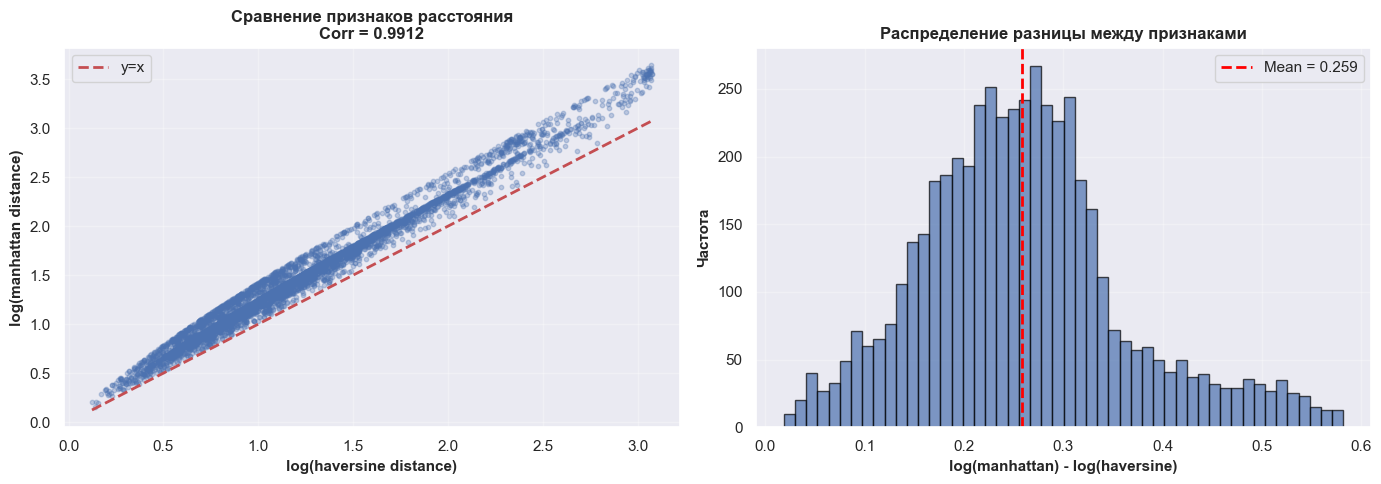

<Figure size 640x480 with 0 Axes>

In [75]:
print("\n" + "=" * 70)
print("АНАЛИЗ КОРРЕЛЯЦИЙ МЕЖДУ ПРИЗНАКАМИ РАССТОЯНИЯ")
print("=" * 70)

# Проверяем корреляцию между haversine и manhattan
corr_distances = train_df_clean[["log_haversine", "log_manhattan"]].corr()

print("\nКорреляция между log_haversine и log_manhattan:")
print(corr_distances)

print(f"\nКорреляция log_haversine с таргетом:  {corr_haversine:.4f}")
print(f"Корреляция log_manhattan с таргетом: {corr_manhattan:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Scatter plot haversine vs manhattan
sample_viz = train_df_clean.sample(min(5000, len(train_df_clean)), random_state=42)
axes[0].scatter(
    sample_viz["log_haversine"], sample_viz["log_manhattan"], alpha=0.3, s=10
)
axes[0].plot(
    [sample_viz["log_haversine"].min(), sample_viz["log_haversine"].max()],
    [sample_viz["log_haversine"].min(), sample_viz["log_haversine"].max()],
    "r--",
    linewidth=2,
    label="y=x",
)
axes[0].set_xlabel("log(haversine distance)", fontsize=11, weight="bold")
axes[0].set_ylabel("log(manhattan distance)", fontsize=11, weight="bold")
axes[0].set_title(
    f"Сравнение признаков расстояния\nCorr = {corr_distances.iloc[0,1]:.4f}",
    fontsize=12,
    weight="bold",
)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение разницы
diff = sample_viz["log_manhattan"] - sample_viz["log_haversine"]
axes[1].hist(diff, bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(
    diff.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {diff.mean():.3f}",
)
axes[1].set_xlabel("log(manhattan) - log(haversine)", fontsize=11, weight="bold")
axes[1].set_ylabel("Частота", fontsize=11, weight="bold")
axes[1].set_title("Распределение разницы между признаками", fontsize=12, weight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/distance_correlation_analysis.png")

## Задание 17: H3 Трансформер

In [81]:
import h3

class H3Transformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для создания признаков на основе шестигранной сетки H3

    Parameters:
    -----------
    resolution : int, default=8
        Разрешение H3 (0-15). Чем больше, тем мельче ячейки:
        - 7: ~5.16 km² per cell (хорошо для больших городов)
        - 8: ~0.74 km² per cell (оптимально для NYC)
        - 9: ~0.10 km² per cell (детально, но медленно)

    add_statistics : bool, default=True
        Добавлять ли статистические признаки по ячейкам

    min_samples_for_stats : int, default=30
        Минимальное количество поездок в ячейке для расчета статистик
    """

    def __init__(self, resolution=8, add_statistics=True, min_samples_for_stats=30):
        self.resolution = resolution
        self.add_statistics = add_statistics
        self.min_samples_for_stats = min_samples_for_stats
        self.cell_stats_ = None
        self.neighbor_stats_ = None

    def _lat_lon_to_h3(self, lat, lon):
        """Конвертирует координаты в H3 индекс (векторизованно)"""
        if isinstance(lat, pd.Series):
            return lat.combine(
                lon, lambda la, lo: h3.latlng_to_cell(la, lo, self.resolution)
            )
        else:
            return h3.latlng_to_cell(lat, lon, self.resolution)

    def _h3_distance(self, h3_1, h3_2):
        """
        Вычисляет расстояние между двумя H3 ячейками в количестве шагов
        (векторизованно через apply)
        """
        if isinstance(h3_1, pd.Series):
            return h3_1.combine(h3_2, lambda h1, h2: h3.grid_distance(h1, h2))
        else:
            return h3.grid_distance(h3_1, h3_2)

    def _calculate_cell_statistics(self, df, target_col="log_trip_duration"):
        """
        Вычисляет статистики по ячейкам БЕЗ утечки целевой переменной

        Статистики считаются только по обучающей выборке!
        """
        stats = {}

        # Для pickup ячеек
        pickup_stats = df.groupby("pickup_h3").agg(
            {target_col: ["mean", "median", "std", "count"]}
        )[target_col]

        pickup_stats.columns = [
            "pickup_h3_mean",
            "pickup_h3_median",
            "pickup_h3_std",
            "pickup_h3_count",
        ]

        # Фильтруем редкие ячейки
        pickup_stats = pickup_stats[
            pickup_stats["pickup_h3_count"] >= self.min_samples_for_stats
        ]

        stats["pickup"] = pickup_stats

        # Для dropoff ячеек
        dropoff_stats = df.groupby("dropoff_h3").agg(
            {target_col: ["mean", "median", "std", "count"]}
        )[target_col]

        dropoff_stats.columns = [
            "dropoff_h3_mean",
            "dropoff_h3_median",
            "dropoff_h3_std",
            "dropoff_h3_count",
        ]

        dropoff_stats = dropoff_stats[
            dropoff_stats["dropoff_h3_count"] >= self.min_samples_for_stats
        ]

        stats["dropoff"] = dropoff_stats

        return stats

    def _get_neighbor_cells(self, h3_cell, k=1):
        """Получает соседние ячейки (k-ring)"""
        try:
            return h3.grid_disk(h3_cell, k)
        except:
            return set()

    def _calculate_neighbor_statistics(self, df, target_col="log_trip_duration"):
        """
        Вычисляет статистики по соседним ячейкам
        (среднее время поездки в окрестности)
        """
        neighbor_stats = {}

        # Для каждой уникальной pickup ячейки
        unique_cells = df["pickup_h3"].unique()

        print(f"Вычисление статистик для {len(unique_cells)} уникальных ячеек...")

        for cell in unique_cells[:1000]:  # Ограничиваем для производительности
            # Получаем соседей
            neighbors = self._get_neighbor_cells(cell, k=1)

            # Считаем статистику по поездкам из соседних ячеек
            neighbor_trips = df[df["pickup_h3"].isin(neighbors)]

            if len(neighbor_trips) >= self.min_samples_for_stats:
                neighbor_stats[cell] = {
                    "neighbor_mean": neighbor_trips[target_col].mean(),
                    "neighbor_count": len(neighbor_trips),
                }

        return pd.DataFrame.from_dict(neighbor_stats, orient="index")

    def fit(self, X, y=None):
        """
        Обучение трансформера - вычисление статистик по обучающей выборке

        Parameters:
        -----------
        X : DataFrame
            Должен содержать колонки: pickup_latitude, pickup_longitude,
            dropoff_latitude, dropoff_longitude, и опционально log_trip_duration
        y : Series, optional
            Целевая переменная (если не в X)
        """
        print(f"=" * 70)
        print(f"Обучение H3Transformer (resolution={self.resolution})")
        print(f"=" * 70)

        # Проверяем наличие необходимых колонок
        required_cols = [
            "pickup_latitude",
            "pickup_longitude",
            "dropoff_latitude",
            "dropoff_longitude",
        ]

        for col in required_cols:
            if col not in X.columns:
                raise ValueError(f"Колонка {col} не найдена в данных!")

        # Создаем временную копию для расчета статистик
        X_copy = X.copy()

        if y is not None and "log_trip_duration" not in X_copy.columns:
            X_copy["log_trip_duration"] = y

        # Конвертируем координаты в H3
        print("Конвертация координат в H3 индексы...")
        X_copy["pickup_h3"] = self._lat_lon_to_h3(
            X_copy["pickup_latitude"], X_copy["pickup_longitude"]
        )
        X_copy["dropoff_h3"] = self._lat_lon_to_h3(
            X_copy["dropoff_latitude"], X_copy["dropoff_longitude"]
        )

        print(f"Уникальных pickup H3 ячеек: {X_copy['pickup_h3'].nunique()}")
        print(f"Уникальных dropoff H3 ячеек: {X_copy['dropoff_h3'].nunique()}")

        # Вычисляем статистики (если требуется и есть таргет)
        if self.add_statistics and "log_trip_duration" in X_copy.columns:
            print("\nВычисление статистик по ячейкам...")
            self.cell_stats_ = self._calculate_cell_statistics(X_copy)
            print(f"✓ Статистики для {len(self.cell_stats_['pickup'])} pickup ячеек")
            print(f"✓ Статистики для {len(self.cell_stats_['dropoff'])} dropoff ячеек")

        print(f"\n{'='*70}")
        print("Обучение завершено!")
        print(f"{'='*70}\n")

        return self

    def transform(self, X):
        """
        Преобразование данных - добавление H3 признаков

        Parameters:
        -----------
        X : DataFrame
            Входные данные

        Returns:
        --------
        DataFrame с добавленными признаками
        """
        X_transformed = X.copy()

        # 1. Конвертируем координаты в H3
        print("Создание H3 признаков...")
        X_transformed["pickup_h3"] = self._lat_lon_to_h3(
            X_transformed["pickup_latitude"], X_transformed["pickup_longitude"]
        )
        X_transformed["dropoff_h3"] = self._lat_lon_to_h3(
            X_transformed["dropoff_latitude"], X_transformed["dropoff_longitude"]
        )

        # 2. Расстояние в H3 ячейках (количество шагов)
        print("Вычисление H3 расстояния...")
        X_transformed["h3_distance"] = self._h3_distance(
            X_transformed["pickup_h3"], X_transformed["dropoff_h3"]
        )

        # 3. Бинарный признак: поездка внутри одной ячейки
        X_transformed["same_h3_cell"] = (
            X_transformed["pickup_h3"] == X_transformed["dropoff_h3"]
        ).astype(int)

        # 4. Добавляем статистические признаки
        if self.add_statistics and self.cell_stats_ is not None:
            print("Добавление статистических признаков...")

            # Pickup статистики
            for col in self.cell_stats_["pickup"].columns:
                X_transformed[col] = X_transformed["pickup_h3"].map(
                    self.cell_stats_["pickup"][col]
                )

            # Dropoff статистики
            for col in self.cell_stats_["dropoff"].columns:
                X_transformed[col] = X_transformed["dropoff_h3"].map(
                    self.cell_stats_["dropoff"][col]
                )

            # Заполняем пропуски медианными значениями
            stat_cols = [col for col in X_transformed.columns if "_h3_" in col]
            for col in stat_cols:
                if col.endswith("_count"):
                    X_transformed[col].fillna(0, inplace=True)
                else:
                    X_transformed[col].fillna(X_transformed[col].median(), inplace=True)

            # Разница между средним временем в pickup и dropoff ячейке
            if (
                "pickup_h3_mean" in X_transformed.columns
                and "dropoff_h3_mean" in X_transformed.columns
            ):
                X_transformed["h3_mean_diff"] = (
                    X_transformed["pickup_h3_mean"] - X_transformed["dropoff_h3_mean"]
                )

        # 5. Удаляем сами H3 индексы (они категориальные и их слишком много)
        # Оставляем только численные признаки
        X_transformed = X_transformed.drop(columns=["pickup_h3", "dropoff_h3"])

        print(
            f"✓ Добавлено {len([c for c in X_transformed.columns if c not in X.columns])} новых признаков"
        )

        return X_transformed

    def visualize_h3_grid(self, df_sample, save_path="h3_grid_map.html"):
        """
        Визуализирует H3 сетку на карте

        Parameters:
        -----------
        df_sample : DataFrame
            Образец данных для визуализации
        save_path : str
            Путь для сохранения HTML карты
        """
        import folium

        # Создаем карту
        center_lat = df_sample["pickup_latitude"].mean()
        center_lon = df_sample["pickup_longitude"].mean()

        m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

        # Получаем уникальные H3 ячейки
        sample_cells = df_sample["pickup_h3"].value_counts().head(50).index

        # Рисуем каждую ячейку
        for cell in sample_cells:
            # Получаем границы ячейки
            boundary = h3.cell_to_boundary(cell)

            # Конвертируем в формат для folium
            boundary_coords = [[lat, lon] for lat, lon in boundary]

            # Рисуем полигон
            folium.Polygon(
                locations=boundary_coords,
                color="blue",
                weight=2,
                fill=True,
                fill_color="blue",
                fill_opacity=0.1,
                popup=f"H3: {cell}",
            ).add_to(m)

        # Сохраняем
        m.save(save_path)
        print(f"Карта H3 сетки сохранена: {save_path}")

        return m

In [82]:
# Создаем трансформер
h3_transformer = H3Transformer(
    resolution=8, add_statistics=True, min_samples_for_stats=50
)

In [ ]:
# Обучаем на train
h3_transformer.fit(train_df_clean, y_train_clean)

Обучение H3Transformer (resolution=8)
Конвертация координат в H3 индексы...
Уникальных pickup H3 ячеек: 702
Уникальных dropoff H3 ячеек: 1397

Вычисление статистик по ячейкам...
✓ Статистики для 183 pickup ячеек
✓ Статистики для 342 dropoff ячеек

Обучение завершено!



,resolution,8
,add_statistics,True
,min_samples_for_stats,50


In [86]:
# Применяем к train и test
print("\nПреобразование обучающей выборки...")
train_h3 = h3_transformer.transform(train_df_clean)

print("\nПреобразование тестовой выборки...")
test_h3 = h3_transformer.transform(test_df)


Преобразование обучающей выборки...
Создание H3 признаков...
Вычисление H3 расстояния...
Добавление статистических признаков...
✓ Добавлено 11 новых признаков

Преобразование тестовой выборки...
Создание H3 признаков...
Вычисление H3 расстояния...
Добавление статистических признаков...
✓ Добавлено 11 новых признаков


In [97]:
# Визуализируем сетку
temp_sample = train_df_clean.sample(1000, random_state=42).copy()
temp_sample["pickup_h3"] = h3_transformer._lat_lon_to_h3(
    temp_sample["pickup_latitude"], temp_sample["pickup_longitude"]
)
h3_map = h3_transformer.visualize_h3_grid(temp_sample, save_path="data/output/laboratory_work2/h3_grid_map.html")

# Показываем новые признаки
new_features = [col for col in train_h3.columns if col not in train_df_clean.columns]
print(f"\n✓ Новые H3 признаки ({len(new_features)}):")
for feat in new_features:
    print(f"  - {feat}")

print("\n" + "=" * 70)

Карта H3 сетки сохранена: data/output/laboratory_work2/h3_grid_map.html

✓ Новые H3 признаки (11):
  - h3_distance
  - same_h3_cell
  - pickup_h3_mean
  - pickup_h3_median
  - pickup_h3_std
  - pickup_h3_count
  - dropoff_h3_mean
  - dropoff_h3_median
  - dropoff_h3_std
  - dropoff_h3_count
  - h3_mean_diff



In [89]:
# Обучение модели с H3 признаками
# Определяем новые числовые признаки (H3 признаки)
h3_numerical_features = [
    "h3_distance",
    "same_h3_cell",
    "pickup_h3_mean",
    "pickup_h3_median",
    "pickup_h3_std",
    "pickup_h3_count",
    "dropoff_h3_mean",
    "dropoff_h3_median",
    "dropoff_h3_std",
    "dropoff_h3_count",
    "h3_mean_diff",
]

# Фильтруем только существующие признаки
h3_numerical_features = [f for f in h3_numerical_features if f in train_h3.columns]

# Комбинируем со всеми предыдущими признаками
all_numerical_features = numerical_features_manhattan.copy()
for feat in h3_numerical_features:
    if feat not in all_numerical_features:
        all_numerical_features.append(feat)

print(f"\nЧисловые признаки ({len(all_numerical_features)}):")
for i, feat in enumerate(all_numerical_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nКатегориальные признаки ({len(categorical_features_3)}):")
for i, feat in enumerate(categorical_features_3, 1):
    print(f"  {i:2d}. {feat}")


Числовые признаки (26):
   1. day_of_year
   2. is_blizzard
   3. is_new_year
   4. log_haversine
   5. is_rush_hour
   6. is_free_traffic
   7. pickup_jfk
   8. dropoff_jfk
   9. pickup_lga
  10. dropoff_lga
  11. pickup_penn
  12. dropoff_penn
  13. vendor_binary
  14. store_fwd_binary
  15. log_manhattan
  16. h3_distance
  17. same_h3_cell
  18. pickup_h3_mean
  19. pickup_h3_median
  20. pickup_h3_std
  21. pickup_h3_count
  22. dropoff_h3_mean
  23. dropoff_h3_median
  24. dropoff_h3_std
  25. dropoff_h3_count
  26. h3_mean_diff

Категориальные признаки (6):
   1. day_of_week
   2. month
   3. hour
   4. pickup_cell
   5. dropoff_cell
   6. passenger_count


In [90]:
# Создаем препроцессор
preprocessor_h3 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), all_numerical_features),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=True, handle_unknown="ignore"),
            categorical_features_3,
        ),
    ],
    sparse_threshold=0.3,
)

In [91]:
# Создаем модель
model_h3 = Pipeline(
    [
        ("preprocessor", preprocessor_h3),
        ("regressor", Ridge(alpha=1.0)),
    ]
)

In [92]:
# Подготавливаем данные
X_train_h3 = train_h3[categorical_features_3 + all_numerical_features]
X_test_h3 = test_h3[categorical_features_3 + all_numerical_features]

In [93]:
print("Обучение модели...")
model_h3.fit(X_train_h3, y_train_clean)

Обучение модели...


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [94]:
# Предсказываем
y_pred_train_h3 = model_h3.predict(X_train_h3)
y_pred_test_h3 = model_h3.predict(X_test_h3)

In [96]:
# Считаем метрики
rmsle_train_h3 = rmsle(y_train_clean, y_pred_train_h3)
rmsle_test_h3 = rmsle(y_test, y_pred_test_h3)
rmsle_train_h3, rmsle_test_h3

(np.float64(0.37349702849847516), np.float64(0.47415277903079067))